# Classifying Bird Sounds: part 2
## The obsession continues…and ends

In previous posts, I tried classifying sound by calculating the binned periodogram, which is a quite similar to the Mel frequency, as a feature. I used a simple 3-layer neural network and CNN. But, audio signals are very long because the sampling frequency is very fast, I could only load 100 of the .mp3 samples in a resonable amount of time.

This time I tried both time and frequency features such that I can have a diversity of features. I also downsampled each feature to a certain length so that I could load more .mp3 samples. The features tested are :

    1. audio time-series downsampled (time feature),
    2. audio signature which is a snapshot of the audio signal that repeats the most (time feature),
    3. two principle components of the audio signal downsampled using PCA (time feature),
    4. binned periodogram (frequency feature),
    5. mel-cestral frequency (frequency feature),
    6. five discrete time wavelets (frequency feature),
    7. trunctated flattened short-time fft (time-frequency feature),
    8. truncated flattened continuous wavelet transform (time-frequency feature).

These signals are all downsampled or the 2D image is resized such that they are all a fixed controlled length, such as 500 timesteps long. In this way, I can have a managable quantity of the data.

<img src="speaker.png" alt="Drawing" style="width: 300px;"/>

In [2]:
import os
from os import path

import numpy as np
from numpy.linalg import norm

import pandas as pd

# Signal processing
from scipy.io import wavfile
from scipy.interpolate import interp1d
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import find_peaks

# Audio processing
from pydub import AudioSegment

# MFCC
import librosa, librosa.display

# Wavelet 
import pywt
from pywt import wavedec

# Visualization
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import IPython

# to display full dataframe information
pd.set_option('display.max_colwidth', None)

from PIL import Image

from mlxtend.preprocessing import minmax_scaling

import pickle

from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

import os
import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
tf.compat.v1.enable_eager_execution()  # This allows you to use placeholder in version 2.0 or higher
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

# LSTM
from tensorflow.keras.layers import LSTM, Dense

# Transformer
from tensorflow.keras.layers import Embedding, MultiHeadAttention, Dense, Input, Dropout, LayerNormalization

# N-Layer NN
from tensorflow.keras.layers import LeakyReLU, Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization

# CNN
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten, GlobalMaxPool2D, MaxPool2D, concatenate, Activation)

np.random.seed(1)

2022-06-19 11:20:45.388912: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-19 11:20:45.389012: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Pre-processing

## Load csv for ylabels

In [ ]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Load train data from xls file
# Path of the file to read: this gives the 
# organization of the included data files
data_filepath = "../input/xenocanto-avian-vocalizations-canv-usa/xeno-canto_ca-nv_index.csv"
df = pd.read_csv(data_filepath)

In [4]:
# PC
pathname = "/home/oem2/Documents/PROGRAMMING/Github_analysis_PROJECTS/Sound_analysis/Son_des_oiseaux/"

data_filepath = pathname + "xeno-canto_ca-nv_index.csv"
df = pd.read_csv(data_filepath)

# Subfunctions

See the github repository for all the subfunctions used: https://github.com/j622amilah/Son_des_oiseaux2/

In [5]:
def catstrvec_2_catnumvec(strcats, df_col):
    act_val = []
    for i in df_col.to_numpy():
        xy, x_ind, y_ind = np.intersect1d(strcats, i, return_indices=True)
        act_val.append(x_ind[0])
    
    return act_val

In [6]:
def convert_mp3_to_sig(audio_filepath):
    # files                                                                         
    src = audio_filepath
    dst = "test.wav"

    # convert wav to mp3                                                            
    sound = AudioSegment.from_mp3(src)
    sound.export(dst, format="wav")
    
    return dst

In [7]:
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

In [8]:
# Calculate and plot spectrogram for a wav audio file
# Binning the time-series and calculating the periodogram per time bin

def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    # print('size of extracted data from sound file: ', data.shape)
    nfft = 100 # Length of each window segment - frequency data will be binned by nfft/2 
    fs = 8000 # Sampling frequencies
    noverlap = 0 #120 # Overlap between windows
    nchannels = data.ndim
    # print('nchannels: ', nchannels)
    
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.spectrogram.html
    
    # OR
    
    # pxx = periodogram per frequency (nfft/2 = num_of_freqs, bins=num_of_bins)
    # freqs = freqencies that correspond to each magnitude
    # bins = number of bins to group time-series
    # im = the image of the axis
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap=noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap=noverlap)
        
    # print('number of bins: ', bins.shape)
    # print('shape of pxx: ', pxx.shape)
    # print('shape of freqs: ', freqs.shape)
    
    plotORnot = 0
    if plotORnot == 1:
        plt.ylabel("Frequency")
        plt.xlabel("Number of time windows")
        plt.title("Spectrogram")
        plt.show()

    return data, pxx, freqs

In [9]:
def make_a_properlist(vec):
    
    out = []
    for i in range(len(vec)):
        out = out + [np.ravel(vec[i])]
        
    if is_empty(out) == False:
        vecout = np.concatenate(out).ravel().tolist()
    else:
        vecout = list(np.ravel(out))
    
    return vecout

def is_empty(vec):
    vec = np.array(vec)
    if vec.shape[0] == 0:
        out = True
    else:
        out = False
        
    return out

In [10]:
def linear_intercurrentpt_makeshortSIGlong_interp1d(shortSIG, longSIG):

    x = np.linspace(shortSIG[0], len(shortSIG), num=len(shortSIG), endpoint=True)
    y = shortSIG
    # print('x : ', x)


    # -------------
    kind = 'linear'
    # kind : Specifies the kind of interpolation as a string or as an integer specifying the order of the spline interpolator to use. The string has to be one of ‘linear’, ‘nearest’, ‘nearest-up’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, or ‘next’. ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; ‘previous’ and ‘next’ simply return the previous or next value of the point; ‘nearest-up’ and ‘nearest’ differ when interpolating half-integers (e.g. 0.5, 1.5) in that ‘nearest-up’ rounds up and ‘nearest’ rounds down. Default is ‘linear’.

    if kind == 'linear':
        f = interp1d(x, y)
    elif kind == 'cubic':
        f = interp1d(x, y, kind='cubic')
    # -------------

    xnew = np.linspace(shortSIG[0], len(shortSIG), num=len(longSIG), endpoint=True)
    # print('xnew : ', xnew)

    siglong = f(xnew)

    return siglong

In [11]:
def scale_feature_data(feat, plotORnot, type_scale):
    
    columns = ['0']
    dat = pd.DataFrame(data=feat, columns=columns)
    
    # which type of scaling
    if type_scale == 'minmax':
        # Values from 0 to 1
        scaled_data0 = minmax_scaling(dat, columns=columns)
        scaled_data = list(scaled_data0.to_numpy().ravel())
        
    elif type_scale == 'normalization':
        # normalization : same as mlxtend - Values from 0 to 1
        scaled_data = []
        for q in range(len(feat)):
            scaled_data.append( (feat[q] - np.min(feat))/(np.max(feat) - np.min(feat)) )
    
    elif type_scale == 'pos_normalization':
        # positive normalization : same as mlxtend - Values from 0 to 1
        shift_up = [i - np.min(feat) for i in feat]
        scaled_data = [q/np.max(shift_up) for q in shift_up]
    
    elif type_scale == 'standardization':
        # standardization : values are not restricted to a range, but scaled appropreately
        scaled_data = [(q - np.mean(feat))/np.std(feat) for q in feat]

    return scaled_data

In [12]:
# level : the number of levels to decompose the time signal, le nombre des marquers par signale
def tsig_2_discrete_wavelet_transform(sig, waveletname, level, plotORnot):

    # On peut calculater dans deux façons: 0) dwt en boucle and then idwt, 1) wavedec et waverec
    # Mais le deux ne donnent pas le meme reponses, wavedec et waverec semble plus raisonable.
    coeff = wavedec(sig, waveletname, level)

    if plotORnot == 1:
        fig, axx = plt.subplots(nrows=len(coeff), ncols=1, figsize=(5,5))
        axx[0].set_title("coef")  # Pas certain si c'est coef0 ou coef1
        for k in range(len(coeff)):
            axx[k].plot(coeff[k], 'r') # output of the low pass filter (averaging filter) of the DWT
        plt.tight_layout()
        plt.show()

    return coeff

In [13]:
def tsig_2_spectrogram(sig, fs, nfft, noverlap, img_dim, plotORnot):

    # -----------------------------------
    fig,ax = plt.subplots(1)
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
    ax.axis('off')
    # spectrum2D array : Columns are the periodograms of successive segments.
    # freqs1-D array : The frequencies corresponding to the rows in spectrum.
    # t1-D array : The times corresponding to midpoints of segments (i.e., the columns in spectrum).
    # imAxesImage : The image created by imshow containing the spectrogram.
    pxx, freqs, bins, img = ax.specgram(sig, nfft, fs, noverlap=noverlap)
    ax.axis('off')

    # -----------------------------------

    my_image = 'temp.png'
    fig.savefig(my_image)
    fname = os.path.abspath(os.getcwd()) + "/" +  my_image
    
    # Convert image to an array:
    # Read image 
    img = Image.open(fname)         # PIL: img is not in array form, it is a PIL.PngImagePlugin.PngImageFile 

    # -----------------------------------
    
    # Resize sectrogram image
    image = imgORmat_resize_imgORmat_CNN(img_dim, data_in=img, inpt='img3D', outpt='mat2D', norm='non', thresh='non')
    
    # -----------------------------------
    
    # Flatten image into a vector
    img_flatten = np.reshape(np.ravel(image), (img_dim*img_dim, ), order='F')
    # print('img_flatten.shape: ', img_flatten.shape)

    # -----------------------------------

    return img_flatten

In [14]:
def tsig_2_continuous_wavelet_transform(sig, fs, scales, waveletname, img_dim, plotORnot):
    
    # e.g.:
    # scales = np.arange(1, 128)
    # waveletname = 'mexh'
    # sig = data2[0:100]
    # print('len(sig): ', len(sig))
    
    dt = 1/fs
    # print('dt : ', dt)

    coefficients, frequencies = pywt.cwt(sig, scales, waveletname, dt)
    coefficients = np.array(coefficients)
    ylen, xlen = coefficients.shape

    # Time by frequency plot of cwt : then flatten and use as a feature
    stop_val = len(sig)/fs
    x = np.arange(0, stop_val, dt)  # time
    y = frequencies # frequency 
    X, Y = np.meshgrid(x, y)
    Z = coefficients

    # Each cwt versus frequencies
    # for i in range(len(coefficients)):
    #     plt.plot(frequencies, coefficients[i])

    #  
    fig = plt.figure()
    ax = plt.axes() # creates a 3D axis by using the keyword projection='3d'
    ax.contourf(X, Y, Z, xlen, cmap=plt.cm.seismic) # contour fill
    ax.axis('off')

    # -----------------------------------

    my_image = 'temp.png'
    fig.savefig(my_image)
    fname = os.path.abspath(os.getcwd()) + "/" +  my_image

    # Convert image to an array:
    # Read image 
    img = Image.open(fname)  
    
    # -----------------------------------
    
    # Resize sectrogram image
    image = imgORmat_resize_imgORmat_CNN(img_dim, data_in=img, inpt='img3D', outpt='mat2D', norm='non', thresh='non')
    
    # -----------------------------------
    
    # Flatten image into a vector
    img_flatten = np.reshape(np.ravel(image), (img_dim*img_dim, ), order='F')
    # print('img_flatten.shape: ', img_flatten.shape)
    
    return img_flatten

In [15]:
def resize_img(img, img_dim):
    if type(img) == 'numpy.ndarray':
        # img is an array, retuns an image object
        rgb_image = Image.fromarray(img , 'RGB')
    else:
        # img is an image object, returns an image object
        try:
            rgb_image = img.convert('RGB')
        except AttributeError:
            rgb_image = Image.fromarray(img , 'RGB')

    # Resize image into a 64, 64, 3
    new_h, new_w = int(img_dim), int(img_dim)
    img3 = rgb_image.resize((new_w, new_h), Image.ANTIALIAS)
    w_resized, h_resized = img3.size[0], img3.size[1]
    return img3

def convert_img_a_mat(img, outpt):
    mat = np.array(img)  # Convert image to an array
    if outpt == 'mat2D':
        # Transformer l'image de 3D à 2D
        # Convert image back to a 2D array
        matout = np.mean(mat, axis=2)
    elif outpt == 'img3D': # techniquement c'est un image parce qu'il y a trois RGB channels 
        matout = mat
    return matout

def norm_mat(mat2Dor3D, norm):
    if norm == 'zero2one':
        # Normalizer l'image entre 0 et 1
        norout = mat2Dor3D/255
    elif norm == 'negone2posone':
        # Normalize the images to [-1, 1]
        norout = (mat2Dor3D - 127.5) / 127.5
    elif norm == 'non':
        norout = mat2Dor3D
    return norout

def threshold_mat(mat2D, thresh):
    # Threshold image
    val = 255/2
    if thresh == 'zero_moins_que_val':
        row, col = mat2D.shape
        mat_thresh = mat2D
        min_val = np.min(mat_thresh)
        for i in range(row):
            for j in range(col):
                if mat_thresh[i,j] < val:
                    mat_thresh[i,j] = min_val
    elif thresh == 'non':
        mat_thresh = mat2D
    return mat_thresh

def imgORmat_resize_imgORmat_CNN(img_dim, data_in, inpt='img3D', outpt='mat2D', norm='non', thresh='non'):
    if inpt == 'img3D' and outpt=='mat2D':
        img = resize_img(data_in, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)
    elif inpt == 'mat2D' and outpt=='mat2D':
        data_in = np.array(data_in)
        img = Image.fromarray(data_in , 'L')
        img = resize_img(img, img_dim)
        mat2D = convert_img_a_mat(img, outpt)
        out = norm_mat(mat2D, norm)
    elif inpt == 'mat2D' and outpt=='img3D':
        data_in = np.array(data_in)
        img = Image.fromarray(data_in , 'L')
        img = resize_img(img, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)
    elif inpt == 'img3D' and outpt=='img3D':
        img = resize_img(data_in, img_dim)
        img3D = convert_img_a_mat(img, outpt)
        out = norm_mat(img3D, norm)

    return out

In [16]:
def save_dat_pickle(outSIG, file_name="outSIG.pkl"):
    # Save data matrices to file
    open_file = open(file_name, "wb")
    pickle.dump(outSIG, open_file)
    open_file.close()

In [17]:
def load_dat_pickle(file_name="outSIG.pkl"):
    open_file = open(file_name, "rb")
    dataout = pickle.load(open_file)
    open_file.close()
    return dataout

In [18]:
def binarize_Y1Dvec_2_Ybin(Y):
    
    # Transform a 1D Y vector (n_samples by 1) to a Y_bin (n_samples by n_classes) vector

    # Ensure vector is of integers
    Y = [int(i) for i in Y]

    # Number of samples
    m_examples = len(Y)

    # Number of classes
    temp = np.unique(Y)
    unique_classes = [int(i) for i in temp]
    # print('unique_classes : ', unique_classes)

    whichone = 2
    # Binarize the output
    if whichone == 0:
        from sklearn.preprocessing import label_binarize
        Y_bin = label_binarize(Y, classes=unique_classes)  # seems to work now

    elif whichone == 1:
        from sklearn import preprocessing
        lb = preprocessing.LabelBinarizer()
        Y_bin = lb.fit_transform(Y)  # seems to work now
        
    elif whichone == 2:
        # By hand
        Y_bin = np.zeros((m_examples, len(unique_classes)))
        for i in range(0, m_examples):
            if Y[i] == unique_classes[0]:
                Y_bin[i,0] = 1
            elif Y[i] == unique_classes[1]:
                Y_bin[i,1] = 1
            elif Y[i] == unique_classes[2]:
                Y_bin[i,2] = 1
            elif Y[i] == unique_classes[3]:
                Y_bin[i,3] = 1
            elif Y[i] == unique_classes[4]:
                Y_bin[i,4] = 1
            elif Y[i] == unique_classes[5]:
                Y_bin[i,5] = 1
            elif Y[i] == unique_classes[6]:
                Y_bin[i,6] = 1
            elif Y[i] == unique_classes[7]:
                Y_bin[i,7] = 1
            elif Y[i] == unique_classes[8]:
                Y_bin[i,8] = 1
            elif Y[i] == unique_classes[9]:
                Y_bin[i,9] = 1
            elif Y[i] == unique_classes[10]:
                Y_bin[i,10] = 1
                
    print('shape of Y_bin : ', Y_bin.shape)

    return Y_bin, unique_classes

In [19]:
def binarize_audio_signal(wind, data2):
    # wind = 1000
    a = int(np.floor(len(data2)/wind))
    vals = np.arange(0, a*wind, wind)
    sig = [np.max(data2[i:(i+wind)])*np.ones((wind)) for i in vals]    
    sig = make_a_properlist(sig)
    
    return sig

In [20]:
def temporal_repeating_signatures(data2, timesteps, plotORnot):
    
    # ------------------------------------

    # choose wind such that sig is timesteps long
    size_of_mat = timesteps/2
    wind = int(len(data2)/size_of_mat)
    sig = binarize_audio_signal(wind, data2)

    min_border = np.mean(sig) + 1*np.std(sig)

    # On a besoin d'avoir au moins de 2 peaks
    peaks = []
    while len(peaks) < 2:
        # peaks, properties = find_peaks(sig, height=(min_border, np.max(sig)), prominence=100)
        peaks, properties = find_peaks(sig, height=(min_border, np.max(sig)))
        min_border = min_border - 10
    vv = [sig[i] for i in peaks]

    if plotORnot == 1:
        plt.plot(sig)
        plt.plot(peaks, vv, 'r*')
        plt.ylabel("Amplitude")
        plt.xlabel("Data points")
        plt.title("Bird call : binarized data2")
        plt.show()

    # ------------------------------------

    # Calculate the difference in peaks and find the difference that repeats the most
    # This repeating difference is the ideal window to cut the data for bird call temporal signatures
    peakdiff = [peaks[i+1]-peaks[i] for i in range(len(peaks)-1)]
    z = sorted(peakdiff)
    o = [len(list(str(z[i]))) for i in range(len(z))]

    from collections import Counter
    c = Counter(o)
    mc = c.most_common()[0][0]

    for i in range(len(z)):
        if len(list(str(z[i]))) == mc:
            wind = z[i]

    # ------------------------------------

    # Cut the data and compare each binarized piece, using a metric
    # To see which pieces are similar
    a = int(np.floor(len(sig)/wind))
    vals = np.arange(0, a*wind, wind)

    dic = {}
    dic2 = {}
    for i in vals:
        out = []
        out2 = []

        A = sig[i:(i+wind)]
        A = [int(r) for r in A]
        for j in vals:
            # import required libraries
            B = sig[j:(j+wind)]
            B = [int(r) for r in B]

            # cosine similarity
            #cosine = np.dot(A,B)/(norm(A)*norm(B))
            #out.append(cosine)

            # absolute error
            err = [np.abs(A[q]-B[q]) for q in range(len(A))]
            out.append(err)

            # height value
            height = np.max(A)
            out2.append(height)

        dic[i] = out
        dic2[i] = out2

    # ------------------------------------

    # tot = np.array(tot)
    # tot.shape
    # import seaborn as sns
    # sns.heatmap(data=tot, annot=True)

    # ------------------------------------

    # Take the mean across similarity measures for each temporal piece
    zz = [np.mean(dic[vals[i]]) for i in range(len(dic))]
    zz2 = [np.mean(dic2[vals[i]]) for i in range(len(dic2))]

    # ------------------------------------

    # Find the temporal piece that are most similar to all other pieces
    select_crit = 2

    if select_crit == 0:
        # No height restriction
        # ind_piece = np.argmax(zz)  # cosine similarity
        ind_piece = np.argmin(zz)  # absolute error
    elif select_crit == 1:
        # With height restriction
        # use height as threshold for zz
        marg = 1*np.std(sig)
        thresh = np.max(zz2) - marg
        print('thresh : ', thresh)
        # OU
        # thresh = np.min(zz2)
        store = [zz for i in range(len(zz)) if zz2[i] > thresh]

        # the select index using metric (cosine, absolute error)
        # ind_piece = np.argmax(store)  # cosine similarity
        ind_piece = np.argmin(store)  # absolute error
    elif select_crit == 2:
        # Rien a faire avec metrics, choisi par rapport la hauteur
        ind_piece = np.argmax(zz2)
    
    # Plot selected temporal piece, with data
    st = vals[ind_piece]
    endd = st+wind
    sig2 = sig[st:endd]

    if plotORnot == 1:
        plt.plot(sig)
        plt.plot(np.arange(st,endd), sig2)
        plt.ylabel("Amplitude")
        plt.xlabel("Data points")
        plt.title("Non-downsampled : Bird call and call signature")
        plt.show()

    # ------------------------------------

    # Downsampling
    v = downsample_sig(sig2, timesteps)

    # ------------------------------------
        
    return v

In [21]:
def downsample_sig(sig, timesteps):

    # Downsampling
    a = int(np.floor(len(sig)/timesteps))
    vals = np.arange(0, a*timesteps, a)
    v = [sig[i:(i+a)][0] for i in vals] # duh, pick the first point from each window, that is why [0] is there
    
    return v

# Pipeline

## 1. Create the y label from the dataframe names

In [22]:
# son_des_oiseaux2_2
# https://gist.github.com/j622amilah/30725e514a58f997786fd1c395f6df51
strcats = df.english_cname.value_counts().index.to_numpy()
print('Activities include: ', strcats)
num_of_birds = len(strcats)
print('Number of birds: ', num_of_birds)

y = catstrvec_2_catnumvec(strcats, df.english_cname)
y = np.array(y)
print('shape of y: ', y.shape)

Activities include:  ["Abert's Towhee" 'Rock Wren' 'Red-winged Blackbird' 'Red Crossbill'
 'Pygmy Nuthatch' 'Phainopepla' 'Pacific-slope Flycatcher' 'Pacific Wren'
 'Orange-crowned Warbler' 'Oak Titmouse' "Nutting's Flycatcher"
 "Nuttall's Woodpecker" 'Northern Saw-whet Owl' 'Northern Raven'
 'Northern Pygmy Owl' 'Northern Mockingbird' 'Northern Flicker'
 'Mountain Quail' 'Mountain Chickadee' 'Marsh Wren'
 "MacGillivray's Warbler" "Ridgway's Rail" 'Rufous-crowned Sparrow'
 "Lincoln's Sparrow" 'Slate-colored Fox Sparrow' 'Yellow-billed Magpie'
 'Wrentit' "Wilson's Warbler" 'White-headed Woodpecker'
 'White-crowned Sparrow' 'White-breasted Nuthatch' 'Western Wood Pewee'
 'Western Screech Owl' 'Western Meadowlark' 'Warbling Vireo' 'Verdin'
 'Tricolored Blackbird' 'Thick-billed Fox Sparrow' "Swainson's Thrush"
 "Steller's Jay" 'Spotted Towhee' 'Spotted Owl' 'Song Sparrow'
 'Snow Goose' 'Long-eared Owl' 'Lesser Goldfinch' 'Acorn Woodpecker'
 'California Towhee' 'California Scrub Jay' 'Calif

## 2. Load the mp3 files

In [23]:
# son_des_oiseaux2_3

# path = "../input/xenocanto-avian-vocalizations-canv-usa/xeno-canto-ca-nv/"


path = "/home/oem2/Documents/PROGRAMMING/Github_analysis_PROJECTS/Sound_analysis/Son_des_oiseaux/xeno-canto-ca-nv/"
# Get file names 
files = os.listdir(path)
all_fn = []
for f in files:
    fn = f.partition('.')[0]
    
    if fn[0:2] != '__':
        all_fn.append(fn)
print('FILE NAMES: ', all_fn)
print('length of all_fn: ', len(all_fn))

FILE NAMES:  ['XC102955', 'XC103042', 'XC103052', 'XC103087', 'XC103088', 'XC103095', 'XC103428', 'XC104699', 'XC104702', 'XC104710', 'XC104737', 'XC105583', 'XC105643', 'XC105724', 'XC105759', 'XC105763', 'XC106457', 'XC106459', 'XC106641', 'XC109595', 'XC109651', 'XC109664', 'XC109825', 'XC109854', 'XC110259', 'XC110263', 'XC110657', 'XC110658', 'XC110813', 'XC110976', 'XC111439', 'XC111830', 'XC112011', 'XC112498', 'XC113802', 'XC113809', 'XC113818', 'XC113822', 'XC114550', 'XC115815', 'XC118769', 'XC119160', 'XC121020', 'XC121096', 'XC121125', 'XC121701', 'XC122615', 'XC122631', 'XC123662', 'XC124421', 'XC124482', 'XC124498', 'XC124600', 'XC124622', 'XC124632', 'XC124641', 'XC124642', 'XC124643', 'XC124647', 'XC124649', 'XC124824', 'XC124828', 'XC124838', 'XC124963', 'XC124998', 'XC124999', 'XC125072', 'XC125082', 'XC125083', 'XC125087', 'XC125178', 'XC125202', 'XC125205', 'XC125218', 'XC125220', 'XC125224', 'XC125227', 'XC125233', 'XC125244', 'XC125250', 'XC125252', 'XC125259', 'X

## 3. Load X matrix

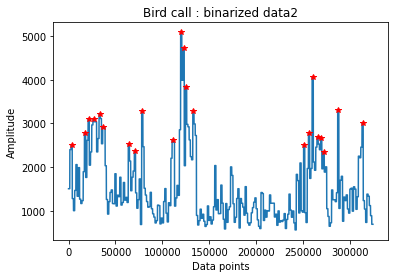

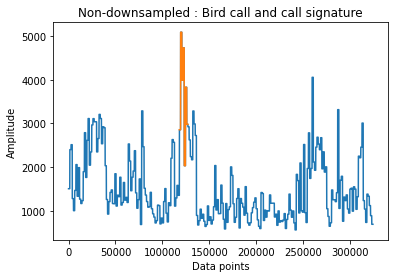

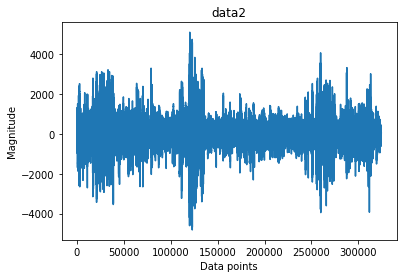

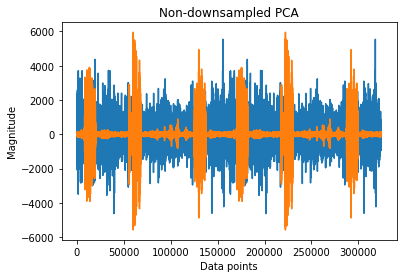

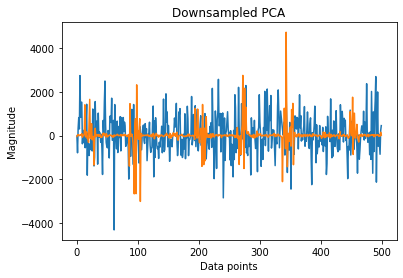

In [24]:
# son_des_oiseaux2_4
try_some = 1 # 100, 300, 500
samps = np.random.permutation(try_some)

X = pd.DataFrame()

timesteps = 500  # 50, 100, 150 (best), 200
longsig = np.arange(timesteps)

plotORnot = 0

for bird in samps:

    audio_filepath = path + all_fn[bird] + '.mp3'
    # ------------------------------------

    # Do steps 1 and 2 to get the rate
    # 1) Converter mp3 à signale
    dst = convert_mp3_to_sig(audio_filepath)

    # 2) Obtenir le fréquence d'échantillonnage
    rate, data = get_wav_info(dst)

    del dst, data

    # ------------------------------------

    # 3) Downsample such that the audio is not distorted
    sound = AudioSegment.from_file(audio_filepath, format='mp3', frame_rate=rate)
    fs = 10000
    sound = sound.set_frame_rate(fs)
    data2 = sound.get_array_of_samples()

    if plotORnot == 1:
        # Confirmer signale
        t = np.linspace(0, len(data2) / fs, len(data2))
        plt.plot(data2)  # freqs is 101 long
        plt.ylabel("Amplitude")
        plt.xlabel("Data points")
        plt.title("Bird call : data2")
        plt.show()

    del sound

    # ------------------------------------

    # Time-series downsampled
    useit = 1
    if useit == 1:
        timsig_down = downsample_sig(data2, timesteps)

        if plotORnot == 1:
            plt.plot(timsig_down)
            plt.ylabel("Amplitude")
            plt.xlabel("Data points")
            plt.title("Downsampled : data2")
            plt.show()

    # ------------------------------------

    # Choose wind such that sig is timesteps long
    useit = 1
    if useit == 1:
        plotORnot = 1
        timeseries_repeat = temporal_repeating_signatures(data2, timesteps, plotORnot)

    # If the mp3 has all other sounds and one or two bird calls, it is likely to find a signature
    # for the other sounds because it partitions the data and looks for similar chunks of data.
    # If you have only bird calls, it will pick up a bird call signature.

    # ------------------------------------

    useit = 1
    if useit == 1:
        # Get the first 3principle componets : Principle Component Analysis (PCA)
        X_dat = [data2, data2]
        X_dat = np.reshape(X_dat, (len(data2), 2))
        feat_PCA = PCA(n_components=2).fit_transform(X_dat)  # shape (len(data2), n_components)

        cols = feat_PCA.shape[1]
        pca_out = []
        for i in range(cols):
            sig = feat_PCA[:,i]
            pca_out.append(downsample_sig(sig, timesteps))

        if plotORnot == 1:
            plt.plot(data2)
            plt.ylabel("Magnitude")
            plt.xlabel("Data points")
            plt.title("data2")
            plt.show()

            plt.plot(feat_PCA[:])
            plt.ylabel("Magnitude")
            plt.xlabel("Data points")
            plt.title("Non-downsampled PCA")
            plt.show()

            plt.plot(pca_out[0])
            plt.plot(pca_out[1])
            plt.ylabel("Magnitude")
            plt.xlabel("Data points")
            plt.title("Downsampled PCA")
            plt.show()

    # ------------------------------------

    useit = 0
    if useit == 1:
        # ....................
        # Binned periodogram
        # ....................
        # Plot directly the periodogram of the signal (Magnitude vs Frequency) : Unmanageable length = 149401
        detrend='linear'
        freqencies, spectrum = periodogram(data2, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum',)

        if plotORnot == 1:
            plt.plot(freqencies, spectrum)
            plt.ylabel("Magnitude")
            plt.xlabel("Frequency")
            plt.title("Periodogram")
            plt.show()

        grp = 550
        spec_bin = [sum(spectrum[i:i+grp]) for i in range(0,len(spectrum), grp)]
        freq_bin = [freqencies[i] for i in range(0,len(freqencies), grp)]

        while len(spec_bin) > timesteps:
            grp = grp+5
            spec_bin = [sum(spectrum[i:i+grp]) for i in range(0,len(spectrum), grp)]
            freq_bin = [freqencies[i] for i in range(0,len(freqencies), grp)]

        if plotORnot == 1:
            plt.plot(freq_bin, spec_bin)
            plt.ylabel("Magnitude")
            plt.xlabel("Frequency")
            plt.title("Periodogram")
            plt.show()

        del spectrum

    # ------------------------------------

    useit = 0
    if useit == 1:
        # ....................
        # MEL frequency
        # ....................
        data2 = np.array(data2)
        data2 = np.float32(data2)
        mfcc = librosa.feature.mfcc(data2)

        mfcc_mean = mfcc.mean(axis=1)  # Manageable length = 20

    # ------------------------------------

    useit = 0
    if useit == 1:
        # ....................
        # Discrete time wavelets
        # ....................
        level = 5
        coeff = tsig_2_discrete_wavelet_transform(data2, 'sym5', level, plotORnot)  # Manageable length = 16

        # Not sure why it gives more than level+1 coefficents
        # Only take level+1
        coeff = coeff[0:level+1]

        # Ensure that all wavelets are no longer than timesteps
        coeff_cut = [coeff[i] if len(coeff[i]) <= timesteps else coeff[i][0:timesteps] for i in range(len(coeff))]

    # ------------------------------------

    useit = 0
    if useit == 1:
        # Selectionez le taille d'image pour le STFFT and CTFFT par rapport le taille des autres marquers 
        img_dim = int(np.sqrt(timesteps))

        # flattened short-time fourier transform : spectrogram
        nfft = 100 # Length of each window segment - frequency data will be binned by nfft/2 
        fs = 8000 # Sampling frequencies
        noverlap = 0 #120 # Overlap between windows - this give data consistency
        stfft = tsig_2_spectrogram(data2, fs, nfft, noverlap, img_dim, plotORnot) # Manageable length = img_dim*img_dim

    # ------------------------------------

    useit = 0
    if useit == 1:
        # Take a fixed small amount of the signal, for slower processing features
        part = 1000
        sig3 = data2[0:part]
        scales = np.arange(1, 128)
        waveletname = 'mexh'

        # Manageable length = img_dim*img_dim
        ctfft = tsig_2_continuous_wavelet_transform(sig3, fs, scales, waveletname, img_dim, plotORnot)

    # ------------------------------------

    # Not all the columns are the same length but we just need to store them somewhere together

    # Time features :
    col0 = pd.Series(timsig_down)
    col1 = pd.Series(timeseries_repeat)
    cols2 = pd.DataFrame(pca_out).T

    # Frequency features :
    #col3 = pd.Series(spec_bin)
    # col4 = pd.Series(mfcc_mean)
    # cols5 = pd.DataFrame(coeff_cut).T
    #col6 = pd.Series(stfft) 
    #col7 = pd.Series(ctfft)

    # df = pd.concat([col0, col1, col2, cols3, col4, col5], axis=1)
    # df = pd.concat([col1, col2, cols3], axis=1)
    # df = pd.concat([col0, cols01, col2, cols3], axis=1)
    df = pd.concat([col0, col1, cols2], axis=1)

    # ------------------------------------

    # Interpolate toutes les vectors
    for i in range(len(df.columns)):
        shortsig = df.iloc[:,i].dropna().to_numpy()
        intrp = linear_intercurrentpt_makeshortSIGlong_interp1d(shortsig, longsig)
        # ------------------------------------

        # Scale toutes les vectors
        type_scale = 'standardization'  # 
        df.iloc[:,i] = scale_feature_data(intrp, plotORnot, type_scale)

    X = pd.concat([X, df], axis=0)


X = X.to_numpy()

save_dat_pickle(X, file_name="X.pkl")
save_dat_pickle(samps, file_name="samps.pkl")

In [ ]:
if os.path.exists("X.pkl") == True:
    X = load_dat_pickle(file_name="X.pkl")
    samps = load_dat_pickle(file_name="samps.pkl")

# Prepare X and y

## Ensuring that X  is correct

In [25]:
print('X.shape : ', X.shape)

batch = len(samps)
# OU
batch = int(X.shape[0]/timesteps)

feature = X.shape[1]

print('batch : ', batch)
print('timesteps : ', timesteps)
print('feature : ', feature)

X.shape :  (500, 4)
batch :  1
timesteps :  500
feature :  4


In [26]:
temp = pd.DataFrame(X[0:timesteps,:])
temp

,0,1,2,3
0,-0.058969,-0.786311,-0.071373,-0.134725
1,-2.351761,-0.786311,-0.941856,0.019925
2,0.833005,-0.786311,0.332815,-0.003692
3,-0.014071,-0.786311,0.889755,0.033064
4,-0.367269,-0.786311,0.297484,-0.063912
...,...,...,...,...
495,0.943753,-0.663389,0.018634,-0.123113
496,-0.383731,-0.663389,-0.537561,-0.049574
497,0.355589,-0.663389,-1.018943,-0.106255
498,0.000895,-0.663389,0.205690,0.259651


In [ ]:
fig = make_subplots(rows=1, cols=1)
for i in range(len(temp.columns)):
    fig.append_trace(go.Scatter(x=np.arange(timesteps), y=temp.iloc[:,i].to_numpy(),), row=1, col=1)
    
fig.update_layout(height=600, width=600, title_text="Stacked Subplots")
fig.show()

## Ensuring that y is correct

200

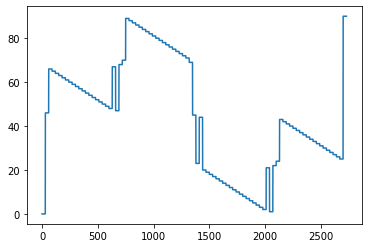

In [27]:
plt.plot(y)

yout = y[samps]
yout = yout[0:batch]
len(yout)

In [28]:
dfy = pd.DataFrame(yout)
vals = sorted([i[0] for i in list(dfy.value_counts().index.to_numpy())])
print('vals : ', vals)
s = []
for ind, i in enumerate(yout):
    # find location of i in vals
    loc = [ind for ind, j in enumerate(vals) if i == j]
    s.append(loc[0])
dfy = pd.DataFrame(s)
num_of_birds = len(dfy.value_counts())
print('number of birds present : ', num_of_birds)
print('s: ', s)

vals :  [0, 46, 62, 63, 64, 65, 66]
number of birds present :  7
s:  [4, 2, 3, 1, 0, 3, 3, 5, 3, 0, 4, 5, 1, 2, 3, 5, 4, 1, 3, 3, 0, 3, 6, 2, 1, 6, 1, 2, 5, 1, 6, 4, 6, 6, 4, 1, 6, 3, 5, 5, 5, 5, 6, 0, 1, 0, 2, 2, 6, 6, 3, 5, 5, 1, 0, 6, 2, 4, 2, 4, 6, 4, 1, 6, 5, 4, 5, 4, 0, 6, 3, 0, 1, 0, 3, 6, 4, 6, 4, 6, 2, 3, 1, 0, 4, 1, 3, 5, 3, 3, 6, 3, 3, 1, 6, 1, 3, 0, 0, 1, 0, 3, 6, 1, 2, 6, 1, 0, 3, 5, 5, 1, 5, 1, 0, 2, 4, 5, 0, 6, 1, 0, 4, 2, 1, 1, 6, 5, 6, 3, 0, 6, 5, 0, 2, 2, 3, 4, 2, 3, 4, 4, 5, 0, 4, 5, 2, 4, 5, 5, 0, 0, 2, 6, 0, 2, 1, 1, 3, 5, 1, 5, 0, 4, 4, 6, 0, 4, 6, 0, 3, 4, 2, 3, 0, 5, 4, 0, 4, 1, 0, 3, 6, 6, 1, 4, 6, 1, 4, 5, 5, 0, 5, 5, 2, 4, 3, 3, 1, 4]


In [85]:
dfy.value_counts()

0    30
1    30
3    30
4    30
5    30
6    30
2    20
dtype: int64

In [106]:
# X.shape :  (batch*timesteps, feature)

X = np.reshape(X, (batch, timesteps, feature))

# ---------------------


# 3 classes only
ind_cl = [ind for ind,i in enumerate(s) if i < 3]
ind_cl

X2 = []
s2 = []
for i in ind_cl:
    X2.append(X[i,:,:])
    s2.append(s[i])


from sklearn.model_selection import train_test_split
X_train, X_test, Y_train_1D, Y_test_1D = train_test_split(X2, s2, 
                                                    train_size=0.8, 
                                                    test_size=0.2, random_state=0)
X_train = np.array(X_train)
print('shape of X_train : ', X_train.shape)
Y_train_1D = np.array(Y_train_1D)
print('shape of Y_train_1D : ', Y_train_1D.shape)
X_test = np.array(X_test)
print('shape of X_test : ', X_test.shape)
Y_test_1D = np.array(Y_test_1D)
print('shape of Y_test_1D : ', Y_test_1D.shape)

# ---------------------

X_train_batch = X_train.shape[0]
X_test_batch = X_test.shape[0]

X_train = np.reshape(X_train, (X_train_batch*timesteps, feature))
X_test = np.reshape(X_test, (X_test_batch*timesteps, feature))

from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
X_train_scaled = scalar.fit_transform(X_train)
X_test_scaled = scalar.transform(X_test)

print('X_train_scaled:' , X_train_scaled.shape)
print('X_test_scaled:' , X_test_scaled.shape)

# ---------------------

# X needs to be size (batch*timesteps, feature)

shape of X_train :  (64, 500, 4)
shape of Y_train_1D :  (64,)
shape of X_test :  (16, 500, 4)
shape of Y_test_1D :  (16,)
X_train_scaled: (32000, 4)
X_test_scaled: (8000, 4)


In [107]:
# ---------------------

# Expand y such that it is the same length as X_train and X_test expanded
y_train_exp = [Y_train_1D[i]*np.ones((timesteps))for i in range(len(Y_train_1D))]    
y_test_exp = [Y_test_1D[i]*np.ones((timesteps))for i in range(len(Y_test_1D))]

# ---------------------

y_train_exp = np.array(y_train_exp)
y_test_exp = np.array(y_test_exp)

y_train_exp = np.reshape(y_train_exp, (y_train_exp.shape[0]*y_train_exp.shape[1]))
y_test_exp = np.reshape(y_test_exp, (y_test_exp.shape[0]*y_test_exp.shape[1]))

print('shape of y_train_exp : ', y_train_exp.shape)
print('shape of y_test_exp : ', y_test_exp.shape)

# ---------------------

Y_bin_train, unique_classes = binarize_Y1Dvec_2_Ybin(y_train_exp)
Y_bin_test, unique_classes = binarize_Y1Dvec_2_Ybin(y_test_exp)

# ---------------------

# Y needs to be size (batch*timesteps, n_outputs)

shape of y_train_exp :  (32000,)
shape of y_test_exp :  (8000,)
shape of Y_bin :  (32000, 3)
shape of Y_bin :  (8000, 3)


# LSTM

In [ ]:
def LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, n_outputs):

    model = Sequential()
    
    model.add(LSTM(n_a, input_shape=(timesteps_train, feature), 
                   return_sequences=return_sequences, return_state=return_state))

    # Types of W initializer :
    initializer = tf.keras.initializers.HeUniform()

    if n_outputs == 2:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))

    # Compile the model for training
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    # opt = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
    # opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, decay=0.01)

    # Si vous utilisez softmax activation, la taille de sortie est plus grand que deux donc il faut categorical_crossentropy
    if n_outputs == 2:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'

    # model.summary()

    return model

In [ ]:
def create_X_batch_timesteps_feature(X, y_bin, input_width, return_sequences):
    
    g = np.argmax(y_bin, axis=1)
    n_outputs = len(np.unique(g))
    print('n_outputs:' , n_outputs)
    
    batch = int(np.floor(X.shape[0]/input_width))

    Xout = []
    yout = []
    for i in range(batch):
        st = i*input_width
        endd = st + input_width
        Xout.append(X[st:endd,:])
        yout.append(y_bin[st:endd,:])

    Xout = np.array(Xout)
    yout = np.array(yout)

    batch, timesteps, feature = Xout.shape
    print('batch:' , batch)
    print('timesteps:' , timesteps)
    print('feature:' , feature)
    
    # ---------------------
    # This part folds y for the return_sequences specification:
    # So you do not need to remember how to fold y
    # ---------------------
    # if return_sequences == True:
        # yout : (batch, timesteps, n_outputs)
    if return_sequences == False:
        # yout : (batch, 1, n_outputs)
        yt = [yout[i,0:1,:] for i in range(batch)]
        yout = np.array(yt)
        yout = np.reshape(yout, (batch, n_outputs))
    # ---------------------
    
    print('Xout:' , Xout.shape)
    print('yout:' , yout.shape)  
        
    tf_data = tf.data.Dataset.from_tensor_slices((Xout, yout))
    tf_data = tf_data.batch(batch)

    return tf_data, Xout, yout, n_outputs

In [108]:
# Initialize

return_sequences = False ## ************* On change ICI *************

input_width = timesteps # It seems like 24 was choosen because perhaps a weather sample was choosen 
# every hour in a span of one day. So we want to look at timestep samples per day.
tf_train, X_train2, y_train2, n_outputs = create_X_batch_timesteps_feature(X_train_scaled, Y_bin_train, input_width, return_sequences)
tf_test, X_test2, y_test2, n_outputs = create_X_batch_timesteps_feature(X_test_scaled, Y_bin_test, input_width, return_sequences)

    
return_state = False # must use functional format to have a and c matricies returned
# ---------------------

n_outputs: 3
batch: 64
timesteps: 500
feature: 4
Xout: (64, 500, 4)
yout: (64, 3)
n_outputs: 3
batch: 16
timesteps: 500
feature: 4
Xout: (16, 500, 4)
yout: (16, 3)


In [110]:
print('X_train2 : ', X_train2.shape)
print('y_train2 :', y_train2.shape)
print('X_test2 : ', X_test2.shape)
print('y_test2 :', y_test2.shape)

timesteps_train = X_train2.shape[1]
feature = X_train2.shape[2]

print('timesteps_train : ', timesteps_train)
print('feature : ', feature)

X_train2 :  (64, 500, 4)
y_train2 : (64, 3)
X_test2 :  (16, 500, 4)
y_test2 : (16, 3)
timesteps_train :  500
feature :  4


In [111]:
epochs = 1200
patience = 5
batch_size = 64

tot = []
tot_mod = []

n_a = 100

model = LSTM_arch(n_a, timesteps_train, feature, return_sequences, return_state, n_outputs)
# -------------------------------

#early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

# history = model.fit(X_train2, y_train2, epochs=epochs, validation_data=(X_test2, y_test2), 
#                    batch_size=batch_size, callbacks=[early_stopping], verbose=2)
history = model.fit(X_train2, y_train2, epochs=epochs, validation_data=(X_test2, y_test2), 
                    batch_size=batch_size, verbose=2)

history_df = pd.DataFrame(history.history)

Epoch 1/1200
1/1 - 3s - loss: 1.1066 - accuracy: 0.2344 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - auc_14: 0.3932 - val_loss: 1.1069 - val_accuracy: 0.1875 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_auc_14: 0.4551 - 3s/epoch - 3s/step
Epoch 2/1200
1/1 - 0s - loss: 1.1040 - accuracy: 0.2500 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - auc_14: 0.4114 - val_loss: 1.1061 - val_accuracy: 0.1250 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_auc_14: 0.4619 - 346ms/epoch - 346ms/step
Epoch 3/1200
1/1 - 0s - loss: 1.1014 - accuracy: 0.2344 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - auc_14: 0.4394 - val_loss: 1.1053 - val_accuracy: 0.0000e+00 - val_precision_14: 0.0000e+00 - val_recall_14: 0.0000e+00 - val_auc_14: 0.4404 - 343ms/epoch - 343ms/step
Epoch 4/1200
1/1 - 0s - loss: 1.0988 - accuracy: 0.2969 - precision_14: 0.0000e+00 - recall_14: 0.0000e+00 - auc_14: 0.4700 - val_loss: 1.1045 - val_accuracy: 0.0625 - val_precision_1

Epoch 32/1200
1/1 - 0s - loss: 1.0427 - accuracy: 0.5000 - precision_14: 0.7500 - recall_14: 0.0469 - auc_14: 0.6761 - val_loss: 1.0959 - val_accuracy: 0.1875 - val_precision_14: 1.0000 - val_recall_14: 0.0625 - val_auc_14: 0.5078 - 339ms/epoch - 339ms/step
Epoch 33/1200
1/1 - 0s - loss: 1.0411 - accuracy: 0.5000 - precision_14: 0.7500 - recall_14: 0.0469 - auc_14: 0.6779 - val_loss: 1.0960 - val_accuracy: 0.1875 - val_precision_14: 1.0000 - val_recall_14: 0.0625 - val_auc_14: 0.5088 - 342ms/epoch - 342ms/step
Epoch 34/1200
1/1 - 0s - loss: 1.0396 - accuracy: 0.5000 - precision_14: 0.7500 - recall_14: 0.0469 - auc_14: 0.6797 - val_loss: 1.0961 - val_accuracy: 0.1875 - val_precision_14: 1.0000 - val_recall_14: 0.0625 - val_auc_14: 0.5117 - 335ms/epoch - 335ms/step
Epoch 35/1200
1/1 - 0s - loss: 1.0380 - accuracy: 0.5000 - precision_14: 0.7500 - recall_14: 0.0469 - auc_14: 0.6818 - val_loss: 1.0962 - val_accuracy: 0.1875 - val_precision_14: 1.0000 - val_recall_14: 0.0625 - val_auc_14: 0.

Epoch 64/1200
1/1 - 0s - loss: 0.9974 - accuracy: 0.5156 - precision_14: 0.6190 - recall_14: 0.2031 - auc_14: 0.6992 - val_loss: 1.1202 - val_accuracy: 0.1875 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.5234 - 337ms/epoch - 337ms/step
Epoch 65/1200
1/1 - 0s - loss: 0.9962 - accuracy: 0.5156 - precision_14: 0.5909 - recall_14: 0.2031 - auc_14: 0.6980 - val_loss: 1.1223 - val_accuracy: 0.1875 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.5215 - 337ms/epoch - 337ms/step
Epoch 66/1200
1/1 - 0s - loss: 0.9951 - accuracy: 0.5156 - precision_14: 0.5652 - recall_14: 0.2031 - auc_14: 0.6984 - val_loss: 1.1246 - val_accuracy: 0.1875 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.5234 - 339ms/epoch - 339ms/step
Epoch 67/1200
1/1 - 0s - loss: 0.9939 - accuracy: 0.5156 - precision_14: 0.5600 - recall_14: 0.2188 - auc_14: 0.6970 - val_loss: 1.1270 - val_accuracy: 0.1875 - val_precision_14: 0.3333 - val_recall_14: 0.1250 - val_auc_14: 0.

Epoch 96/1200
1/1 - 0s - loss: 0.9761 - accuracy: 0.5156 - precision_14: 0.5714 - recall_14: 0.3125 - auc_14: 0.7150 - val_loss: 1.1397 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5312 - 334ms/epoch - 334ms/step
Epoch 97/1200
1/1 - 0s - loss: 0.9756 - accuracy: 0.5156 - precision_14: 0.5714 - recall_14: 0.3125 - auc_14: 0.7158 - val_loss: 1.1384 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5264 - 335ms/epoch - 335ms/step
Epoch 98/1200
1/1 - 0s - loss: 0.9752 - accuracy: 0.5156 - precision_14: 0.5714 - recall_14: 0.3125 - auc_14: 0.7156 - val_loss: 1.1371 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5273 - 332ms/epoch - 332ms/step
Epoch 99/1200
1/1 - 0s - loss: 0.9747 - accuracy: 0.5156 - precision_14: 0.5714 - recall_14: 0.3125 - auc_14: 0.7150 - val_loss: 1.1360 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.

Epoch 128/1200
1/1 - 0s - loss: 0.9611 - accuracy: 0.5156 - precision_14: 0.6364 - recall_14: 0.3281 - auc_14: 0.7198 - val_loss: 1.1294 - val_accuracy: 0.1250 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5371 - 335ms/epoch - 335ms/step
Epoch 129/1200
1/1 - 0s - loss: 0.9606 - accuracy: 0.5156 - precision_14: 0.6364 - recall_14: 0.3281 - auc_14: 0.7212 - val_loss: 1.1290 - val_accuracy: 0.1250 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5371 - 337ms/epoch - 337ms/step
Epoch 130/1200
1/1 - 0s - loss: 0.9601 - accuracy: 0.5156 - precision_14: 0.6364 - recall_14: 0.3281 - auc_14: 0.7214 - val_loss: 1.1286 - val_accuracy: 0.1250 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5391 - 334ms/epoch - 334ms/step
Epoch 131/1200
1/1 - 0s - loss: 0.9596 - accuracy: 0.5156 - precision_14: 0.6364 - recall_14: 0.3281 - auc_14: 0.7219 - val_loss: 1.1283 - val_accuracy: 0.1250 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14

Epoch 160/1200
1/1 - 0s - loss: 0.9414 - accuracy: 0.5469 - precision_14: 0.6875 - recall_14: 0.3438 - auc_14: 0.7339 - val_loss: 1.1219 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5479 - 348ms/epoch - 348ms/step
Epoch 161/1200
1/1 - 0s - loss: 0.9406 - accuracy: 0.5469 - precision_14: 0.6875 - recall_14: 0.3438 - auc_14: 0.7338 - val_loss: 1.1217 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5488 - 345ms/epoch - 345ms/step
Epoch 162/1200
1/1 - 0s - loss: 0.9398 - accuracy: 0.5469 - precision_14: 0.6875 - recall_14: 0.3438 - auc_14: 0.7341 - val_loss: 1.1214 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5488 - 331ms/epoch - 331ms/step
Epoch 163/1200
1/1 - 0s - loss: 0.9390 - accuracy: 0.5469 - precision_14: 0.7097 - recall_14: 0.3438 - auc_14: 0.7339 - val_loss: 1.1212 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14

Epoch 192/1200
1/1 - 0s - loss: 0.9069 - accuracy: 0.5469 - precision_14: 0.6667 - recall_14: 0.3125 - auc_14: 0.7578 - val_loss: 1.1146 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5781 - 403ms/epoch - 403ms/step
Epoch 193/1200
1/1 - 0s - loss: 0.9054 - accuracy: 0.5469 - precision_14: 0.6667 - recall_14: 0.3125 - auc_14: 0.7596 - val_loss: 1.1143 - val_accuracy: 0.1875 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5811 - 464ms/epoch - 464ms/step
Epoch 194/1200
1/1 - 0s - loss: 0.9038 - accuracy: 0.5469 - precision_14: 0.6667 - recall_14: 0.3125 - auc_14: 0.7597 - val_loss: 1.1141 - val_accuracy: 0.2500 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.5840 - 483ms/epoch - 483ms/step
Epoch 195/1200
1/1 - 0s - loss: 0.9021 - accuracy: 0.5469 - precision_14: 0.6667 - recall_14: 0.3125 - auc_14: 0.7625 - val_loss: 1.1137 - val_accuracy: 0.2500 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14

Epoch 224/1200
1/1 - 0s - loss: 0.8125 - accuracy: 0.6719 - precision_14: 0.8571 - recall_14: 0.3750 - auc_14: 0.8188 - val_loss: 1.0685 - val_accuracy: 0.5000 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.6904 - 475ms/epoch - 475ms/step
Epoch 225/1200
1/1 - 0s - loss: 0.8200 - accuracy: 0.6562 - precision_14: 0.8929 - recall_14: 0.3906 - auc_14: 0.8185 - val_loss: 1.0672 - val_accuracy: 0.5000 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.6885 - 483ms/epoch - 483ms/step
Epoch 226/1200
1/1 - 0s - loss: 0.8251 - accuracy: 0.6562 - precision_14: 0.8571 - recall_14: 0.3750 - auc_14: 0.8172 - val_loss: 1.0757 - val_accuracy: 0.5625 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.6914 - 470ms/epoch - 470ms/step
Epoch 227/1200
1/1 - 0s - loss: 0.8117 - accuracy: 0.6875 - precision_14: 0.8929 - recall_14: 0.3906 - auc_14: 0.8221 - val_loss: 1.0910 - val_accuracy: 0.5625 - val_precision_14: 0.3333 - val_recall_14: 0.1250 - val_auc_14

Epoch 256/1200
1/1 - 0s - loss: 0.7984 - accuracy: 0.6562 - precision_14: 0.8182 - recall_14: 0.4219 - auc_14: 0.8337 - val_loss: 1.0826 - val_accuracy: 0.6250 - val_precision_14: 0.4286 - val_recall_14: 0.1875 - val_auc_14: 0.6914 - 489ms/epoch - 489ms/step
Epoch 257/1200
1/1 - 0s - loss: 0.8155 - accuracy: 0.6562 - precision_14: 0.7500 - recall_14: 0.4219 - auc_14: 0.8198 - val_loss: 1.1191 - val_accuracy: 0.5000 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.6738 - 481ms/epoch - 481ms/step
Epoch 258/1200
1/1 - 0s - loss: 0.8347 - accuracy: 0.6562 - precision_14: 0.7568 - recall_14: 0.4375 - auc_14: 0.8066 - val_loss: 1.1321 - val_accuracy: 0.5000 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14: 0.6592 - 485ms/epoch - 485ms/step
Epoch 259/1200
1/1 - 1s - loss: 0.8413 - accuracy: 0.6562 - precision_14: 0.7368 - recall_14: 0.4375 - auc_14: 0.8011 - val_loss: 1.1324 - val_accuracy: 0.5000 - val_precision_14: 0.2857 - val_recall_14: 0.1250 - val_auc_14

Epoch 288/1200
1/1 - 0s - loss: 0.7587 - accuracy: 0.7031 - precision_14: 0.8378 - recall_14: 0.4844 - auc_14: 0.8505 - val_loss: 1.0829 - val_accuracy: 0.6250 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.7266 - 394ms/epoch - 394ms/step
Epoch 289/1200
1/1 - 0s - loss: 0.7548 - accuracy: 0.7031 - precision_14: 0.8611 - recall_14: 0.4844 - auc_14: 0.8522 - val_loss: 1.0850 - val_accuracy: 0.6250 - val_precision_14: 0.4000 - val_recall_14: 0.1250 - val_auc_14: 0.7256 - 458ms/epoch - 458ms/step
Epoch 290/1200
1/1 - 0s - loss: 0.7506 - accuracy: 0.7031 - precision_14: 0.8611 - recall_14: 0.4844 - auc_14: 0.8527 - val_loss: 1.0871 - val_accuracy: 0.6250 - val_precision_14: 0.5000 - val_recall_14: 0.1875 - val_auc_14: 0.7246 - 413ms/epoch - 413ms/step
Epoch 291/1200
1/1 - 0s - loss: 0.7464 - accuracy: 0.7031 - precision_14: 0.8649 - recall_14: 0.5000 - auc_14: 0.8539 - val_loss: 1.0892 - val_accuracy: 0.6250 - val_precision_14: 0.5000 - val_recall_14: 0.1875 - val_auc_14

Epoch 320/1200
1/1 - 0s - loss: 0.6729 - accuracy: 0.7500 - precision_14: 0.8684 - recall_14: 0.5156 - auc_14: 0.8960 - val_loss: 1.1032 - val_accuracy: 0.5625 - val_precision_14: 0.5000 - val_recall_14: 0.1875 - val_auc_14: 0.6953 - 431ms/epoch - 431ms/step
Epoch 321/1200
1/1 - 0s - loss: 0.6701 - accuracy: 0.7500 - precision_14: 0.8684 - recall_14: 0.5156 - auc_14: 0.8979 - val_loss: 1.1065 - val_accuracy: 0.5625 - val_precision_14: 0.5000 - val_recall_14: 0.1875 - val_auc_14: 0.6914 - 402ms/epoch - 402ms/step
Epoch 322/1200
1/1 - 0s - loss: 0.6673 - accuracy: 0.7656 - precision_14: 0.8684 - recall_14: 0.5156 - auc_14: 0.8992 - val_loss: 1.1087 - val_accuracy: 0.5625 - val_precision_14: 0.5000 - val_recall_14: 0.1875 - val_auc_14: 0.6914 - 408ms/epoch - 408ms/step
Epoch 323/1200
1/1 - 0s - loss: 0.6647 - accuracy: 0.7656 - precision_14: 0.8684 - recall_14: 0.5156 - auc_14: 0.8995 - val_loss: 1.1085 - val_accuracy: 0.5625 - val_precision_14: 0.5000 - val_recall_14: 0.1875 - val_auc_14

Epoch 352/1200
1/1 - 1s - loss: 0.6172 - accuracy: 0.7031 - precision_14: 0.8261 - recall_14: 0.5938 - auc_14: 0.9111 - val_loss: 1.1528 - val_accuracy: 0.5625 - val_precision_14: 0.6250 - val_recall_14: 0.3125 - val_auc_14: 0.6396 - 517ms/epoch - 517ms/step
Epoch 353/1200
1/1 - 0s - loss: 0.6143 - accuracy: 0.7031 - precision_14: 0.8261 - recall_14: 0.5938 - auc_14: 0.9117 - val_loss: 1.1525 - val_accuracy: 0.5625 - val_precision_14: 0.6250 - val_recall_14: 0.3125 - val_auc_14: 0.6367 - 420ms/epoch - 420ms/step
Epoch 354/1200
1/1 - 0s - loss: 0.6120 - accuracy: 0.7031 - precision_14: 0.8261 - recall_14: 0.5938 - auc_14: 0.9124 - val_loss: 1.1493 - val_accuracy: 0.5000 - val_precision_14: 0.6250 - val_recall_14: 0.3125 - val_auc_14: 0.6357 - 414ms/epoch - 414ms/step
Epoch 355/1200
1/1 - 0s - loss: 0.6099 - accuracy: 0.7031 - precision_14: 0.8444 - recall_14: 0.5938 - auc_14: 0.9140 - val_loss: 1.1425 - val_accuracy: 0.5000 - val_precision_14: 0.6250 - val_recall_14: 0.3125 - val_auc_14

Epoch 384/1200
1/1 - 0s - loss: 0.5271 - accuracy: 0.7969 - precision_14: 0.9000 - recall_14: 0.7031 - auc_14: 0.9418 - val_loss: 1.3809 - val_accuracy: 0.3125 - val_precision_14: 0.3636 - val_recall_14: 0.2500 - val_auc_14: 0.5566 - 426ms/epoch - 426ms/step
Epoch 385/1200
1/1 - 0s - loss: 0.5245 - accuracy: 0.7969 - precision_14: 0.9000 - recall_14: 0.7031 - auc_14: 0.9420 - val_loss: 1.3831 - val_accuracy: 0.3125 - val_precision_14: 0.3636 - val_recall_14: 0.2500 - val_auc_14: 0.5576 - 393ms/epoch - 393ms/step
Epoch 386/1200
1/1 - 0s - loss: 0.5220 - accuracy: 0.7969 - precision_14: 0.9000 - recall_14: 0.7031 - auc_14: 0.9423 - val_loss: 1.3835 - val_accuracy: 0.3125 - val_precision_14: 0.3636 - val_recall_14: 0.2500 - val_auc_14: 0.5605 - 411ms/epoch - 411ms/step
Epoch 387/1200
1/1 - 0s - loss: 0.5195 - accuracy: 0.7969 - precision_14: 0.9000 - recall_14: 0.7031 - auc_14: 0.9431 - val_loss: 1.3841 - val_accuracy: 0.3125 - val_precision_14: 0.3333 - val_recall_14: 0.2500 - val_auc_14

Epoch 416/1200
1/1 - 0s - loss: 0.4218 - accuracy: 0.8594 - precision_14: 0.9074 - recall_14: 0.7656 - auc_14: 0.9701 - val_loss: 1.4813 - val_accuracy: 0.3750 - val_precision_14: 0.4545 - val_recall_14: 0.3125 - val_auc_14: 0.5830 - 399ms/epoch - 399ms/step
Epoch 417/1200
1/1 - 0s - loss: 0.4178 - accuracy: 0.8594 - precision_14: 0.9057 - recall_14: 0.7500 - auc_14: 0.9706 - val_loss: 1.4883 - val_accuracy: 0.3750 - val_precision_14: 0.5000 - val_recall_14: 0.3750 - val_auc_14: 0.5830 - 401ms/epoch - 401ms/step
Epoch 418/1200
1/1 - 0s - loss: 0.4159 - accuracy: 0.8594 - precision_14: 0.9038 - recall_14: 0.7344 - auc_14: 0.9702 - val_loss: 1.4922 - val_accuracy: 0.3750 - val_precision_14: 0.5000 - val_recall_14: 0.3750 - val_auc_14: 0.5840 - 389ms/epoch - 389ms/step
Epoch 419/1200
1/1 - 0s - loss: 0.4144 - accuracy: 0.8594 - precision_14: 0.9038 - recall_14: 0.7344 - auc_14: 0.9703 - val_loss: 1.4957 - val_accuracy: 0.3750 - val_precision_14: 0.5000 - val_recall_14: 0.3750 - val_auc_14

Epoch 448/1200
1/1 - 0s - loss: 0.3983 - accuracy: 0.8906 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9761 - val_loss: 1.4434 - val_accuracy: 0.5000 - val_precision_14: 0.5455 - val_recall_14: 0.3750 - val_auc_14: 0.6113 - 430ms/epoch - 430ms/step
Epoch 449/1200
1/1 - 0s - loss: 0.3979 - accuracy: 0.8906 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9755 - val_loss: 1.4172 - val_accuracy: 0.4375 - val_precision_14: 0.5455 - val_recall_14: 0.3750 - val_auc_14: 0.6143 - 410ms/epoch - 410ms/step
Epoch 450/1200
1/1 - 0s - loss: 0.3865 - accuracy: 0.8906 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9774 - val_loss: 1.5372 - val_accuracy: 0.3750 - val_precision_14: 0.3333 - val_recall_14: 0.2500 - val_auc_14: 0.5166 - 341ms/epoch - 341ms/step
Epoch 451/1200
1/1 - 0s - loss: 0.3843 - accuracy: 0.8906 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9775 - val_loss: 1.5499 - val_accuracy: 0.3125 - val_precision_14: 0.3077 - val_recall_14: 0.2500 - val_auc_14

Epoch 480/1200
1/1 - 0s - loss: 1.9104 - accuracy: 0.4219 - precision_14: 0.4333 - recall_14: 0.4062 - auc_14: 0.6152 - val_loss: 2.4377 - val_accuracy: 0.1875 - val_precision_14: 0.1875 - val_recall_14: 0.1875 - val_auc_14: 0.4902 - 412ms/epoch - 412ms/step
Epoch 481/1200
1/1 - 0s - loss: 1.8841 - accuracy: 0.4375 - precision_14: 0.4237 - recall_14: 0.3906 - auc_14: 0.6202 - val_loss: 2.3620 - val_accuracy: 0.1875 - val_precision_14: 0.1875 - val_recall_14: 0.1875 - val_auc_14: 0.4854 - 390ms/epoch - 390ms/step
Epoch 482/1200
1/1 - 0s - loss: 1.8519 - accuracy: 0.4375 - precision_14: 0.4483 - recall_14: 0.4062 - auc_14: 0.6222 - val_loss: 2.3024 - val_accuracy: 0.1875 - val_precision_14: 0.1875 - val_recall_14: 0.1875 - val_auc_14: 0.4902 - 337ms/epoch - 337ms/step
Epoch 483/1200
1/1 - 0s - loss: 1.8172 - accuracy: 0.4531 - precision_14: 0.4655 - recall_14: 0.4219 - auc_14: 0.6236 - val_loss: 2.2238 - val_accuracy: 0.1875 - val_precision_14: 0.1875 - val_recall_14: 0.1875 - val_auc_14

Epoch 512/1200
1/1 - 0s - loss: 0.7839 - accuracy: 0.6094 - precision_14: 0.6458 - recall_14: 0.4844 - auc_14: 0.8340 - val_loss: 1.4676 - val_accuracy: 0.2500 - val_precision_14: 0.2727 - val_recall_14: 0.1875 - val_auc_14: 0.4824 - 341ms/epoch - 341ms/step
Epoch 513/1200
1/1 - 0s - loss: 0.7737 - accuracy: 0.6094 - precision_14: 0.6458 - recall_14: 0.4844 - auc_14: 0.8375 - val_loss: 1.4724 - val_accuracy: 0.2500 - val_precision_14: 0.2000 - val_recall_14: 0.1250 - val_auc_14: 0.4678 - 396ms/epoch - 396ms/step
Epoch 514/1200
1/1 - 1s - loss: 0.7649 - accuracy: 0.6094 - precision_14: 0.6596 - recall_14: 0.4844 - auc_14: 0.8389 - val_loss: 1.4768 - val_accuracy: 0.1875 - val_precision_14: 0.2000 - val_recall_14: 0.1250 - val_auc_14: 0.4570 - 554ms/epoch - 554ms/step
Epoch 515/1200
1/1 - 0s - loss: 0.7571 - accuracy: 0.6094 - precision_14: 0.6809 - recall_14: 0.5000 - auc_14: 0.8422 - val_loss: 1.4815 - val_accuracy: 0.1875 - val_precision_14: 0.2000 - val_recall_14: 0.1250 - val_auc_14

Epoch 544/1200
1/1 - 0s - loss: 0.6702 - accuracy: 0.7344 - precision_14: 0.8409 - recall_14: 0.5781 - auc_14: 0.8959 - val_loss: 1.4591 - val_accuracy: 0.3125 - val_precision_14: 0.4000 - val_recall_14: 0.2500 - val_auc_14: 0.4561 - 361ms/epoch - 361ms/step
Epoch 545/1200
1/1 - 0s - loss: 0.6676 - accuracy: 0.7344 - precision_14: 0.8636 - recall_14: 0.5938 - auc_14: 0.8967 - val_loss: 1.4495 - val_accuracy: 0.3125 - val_precision_14: 0.4000 - val_recall_14: 0.2500 - val_auc_14: 0.4629 - 337ms/epoch - 337ms/step
Epoch 546/1200
1/1 - 0s - loss: 0.6652 - accuracy: 0.7344 - precision_14: 0.8478 - recall_14: 0.6094 - auc_14: 0.8979 - val_loss: 1.4408 - val_accuracy: 0.3125 - val_precision_14: 0.4545 - val_recall_14: 0.3125 - val_auc_14: 0.4727 - 324ms/epoch - 324ms/step
Epoch 547/1200
1/1 - 0s - loss: 0.6630 - accuracy: 0.7344 - precision_14: 0.8444 - recall_14: 0.5938 - auc_14: 0.8970 - val_loss: 1.4329 - val_accuracy: 0.3125 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14

Epoch 576/1200
1/1 - 0s - loss: 0.5999 - accuracy: 0.7969 - precision_14: 0.8571 - recall_14: 0.6562 - auc_14: 0.9266 - val_loss: 1.3977 - val_accuracy: 0.3125 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14: 0.5166 - 483ms/epoch - 483ms/step
Epoch 577/1200
1/1 - 0s - loss: 0.5977 - accuracy: 0.7969 - precision_14: 0.8571 - recall_14: 0.6562 - auc_14: 0.9283 - val_loss: 1.3952 - val_accuracy: 0.3125 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14: 0.5166 - 434ms/epoch - 434ms/step
Epoch 578/1200
1/1 - 0s - loss: 0.5954 - accuracy: 0.7969 - precision_14: 0.8571 - recall_14: 0.6562 - auc_14: 0.9286 - val_loss: 1.3930 - val_accuracy: 0.3125 - val_precision_14: 0.4545 - val_recall_14: 0.3125 - val_auc_14: 0.5176 - 338ms/epoch - 338ms/step
Epoch 579/1200
1/1 - 0s - loss: 0.5932 - accuracy: 0.7969 - precision_14: 0.8600 - recall_14: 0.6719 - auc_14: 0.9297 - val_loss: 1.3912 - val_accuracy: 0.3125 - val_precision_14: 0.4545 - val_recall_14: 0.3125 - val_auc_14

Epoch 608/1200
1/1 - 0s - loss: 0.5431 - accuracy: 0.8125 - precision_14: 0.8889 - recall_14: 0.7500 - auc_14: 0.9419 - val_loss: 1.4325 - val_accuracy: 0.3750 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14: 0.5430 - 334ms/epoch - 334ms/step
Epoch 609/1200
1/1 - 0s - loss: 0.5420 - accuracy: 0.8125 - precision_14: 0.8889 - recall_14: 0.7500 - auc_14: 0.9423 - val_loss: 1.4346 - val_accuracy: 0.3750 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14: 0.5439 - 364ms/epoch - 364ms/step
Epoch 610/1200
1/1 - 1s - loss: 0.5408 - accuracy: 0.8125 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9423 - val_loss: 1.4367 - val_accuracy: 0.3750 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14: 0.5430 - 564ms/epoch - 564ms/step
Epoch 611/1200
1/1 - 0s - loss: 0.5397 - accuracy: 0.8125 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9426 - val_loss: 1.4388 - val_accuracy: 0.3750 - val_precision_14: 0.4167 - val_recall_14: 0.3125 - val_auc_14

Epoch 640/1200
1/1 - 0s - loss: 0.5127 - accuracy: 0.8281 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9505 - val_loss: 1.4635 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5410 - 342ms/epoch - 342ms/step
Epoch 641/1200
1/1 - 0s - loss: 0.5119 - accuracy: 0.8281 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9506 - val_loss: 1.4638 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5410 - 336ms/epoch - 336ms/step
Epoch 642/1200
1/1 - 0s - loss: 0.5111 - accuracy: 0.8281 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9507 - val_loss: 1.4641 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5420 - 336ms/epoch - 336ms/step
Epoch 643/1200
1/1 - 0s - loss: 0.5103 - accuracy: 0.8281 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9508 - val_loss: 1.4644 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14

Epoch 672/1200
1/1 - 0s - loss: 0.4861 - accuracy: 0.8281 - precision_14: 0.8929 - recall_14: 0.7812 - auc_14: 0.9590 - val_loss: 1.4826 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.5576 - 327ms/epoch - 327ms/step
Epoch 673/1200
1/1 - 0s - loss: 0.4852 - accuracy: 0.8281 - precision_14: 0.8929 - recall_14: 0.7812 - auc_14: 0.9591 - val_loss: 1.4835 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.5596 - 346ms/epoch - 346ms/step
Epoch 674/1200
1/1 - 0s - loss: 0.4843 - accuracy: 0.8281 - precision_14: 0.8929 - recall_14: 0.7812 - auc_14: 0.9589 - val_loss: 1.4844 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.5605 - 346ms/epoch - 346ms/step
Epoch 675/1200
1/1 - 0s - loss: 0.4834 - accuracy: 0.8281 - precision_14: 0.8929 - recall_14: 0.7812 - auc_14: 0.9589 - val_loss: 1.4853 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14

Epoch 704/1200
1/1 - 0s - loss: 0.4546 - accuracy: 0.8594 - precision_14: 0.9298 - recall_14: 0.8281 - auc_14: 0.9640 - val_loss: 1.5117 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.5537 - 387ms/epoch - 387ms/step
Epoch 705/1200
1/1 - 0s - loss: 0.4538 - accuracy: 0.8594 - precision_14: 0.9298 - recall_14: 0.8281 - auc_14: 0.9639 - val_loss: 1.5122 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5547 - 341ms/epoch - 341ms/step
Epoch 706/1200
1/1 - 0s - loss: 0.4530 - accuracy: 0.8594 - precision_14: 0.9298 - recall_14: 0.8281 - auc_14: 0.9641 - val_loss: 1.5127 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5547 - 341ms/epoch - 341ms/step
Epoch 707/1200
1/1 - 0s - loss: 0.4522 - accuracy: 0.8594 - precision_14: 0.9298 - recall_14: 0.8281 - auc_14: 0.9643 - val_loss: 1.5131 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14

Epoch 736/1200
1/1 - 0s - loss: 0.4293 - accuracy: 0.8594 - precision_14: 0.9464 - recall_14: 0.8281 - auc_14: 0.9694 - val_loss: 1.5533 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5615 - 403ms/epoch - 403ms/step
Epoch 737/1200
1/1 - 0s - loss: 0.4285 - accuracy: 0.8594 - precision_14: 0.9464 - recall_14: 0.8281 - auc_14: 0.9695 - val_loss: 1.5547 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5605 - 344ms/epoch - 344ms/step
Epoch 738/1200
1/1 - 0s - loss: 0.4277 - accuracy: 0.8594 - precision_14: 0.9464 - recall_14: 0.8281 - auc_14: 0.9694 - val_loss: 1.5560 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5605 - 394ms/epoch - 394ms/step
Epoch 739/1200
1/1 - 0s - loss: 0.4269 - accuracy: 0.8594 - precision_14: 0.9464 - recall_14: 0.8281 - auc_14: 0.9695 - val_loss: 1.5574 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14

Epoch 768/1200
1/1 - 0s - loss: 0.4053 - accuracy: 0.8750 - precision_14: 0.9483 - recall_14: 0.8594 - auc_14: 0.9722 - val_loss: 1.5951 - val_accuracy: 0.3750 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.5840 - 415ms/epoch - 415ms/step
Epoch 769/1200
1/1 - 1s - loss: 0.4046 - accuracy: 0.8750 - precision_14: 0.9483 - recall_14: 0.8594 - auc_14: 0.9723 - val_loss: 1.5965 - val_accuracy: 0.3750 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.5850 - 504ms/epoch - 504ms/step
Epoch 770/1200
1/1 - 0s - loss: 0.4040 - accuracy: 0.8750 - precision_14: 0.9483 - recall_14: 0.8594 - auc_14: 0.9726 - val_loss: 1.5979 - val_accuracy: 0.3750 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.5850 - 346ms/epoch - 346ms/step
Epoch 771/1200
1/1 - 0s - loss: 0.4033 - accuracy: 0.8750 - precision_14: 0.9483 - recall_14: 0.8594 - auc_14: 0.9726 - val_loss: 1.5994 - val_accuracy: 0.3750 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14

Epoch 800/1200
1/1 - 0s - loss: 0.6856 - accuracy: 0.7344 - precision_14: 0.7636 - recall_14: 0.6562 - auc_14: 0.8706 - val_loss: 1.6328 - val_accuracy: 0.3125 - val_precision_14: 0.3077 - val_recall_14: 0.2500 - val_auc_14: 0.4912 - 326ms/epoch - 326ms/step
Epoch 801/1200
1/1 - 0s - loss: 0.6624 - accuracy: 0.7344 - precision_14: 0.7925 - recall_14: 0.6562 - auc_14: 0.8805 - val_loss: 1.6539 - val_accuracy: 0.3125 - val_precision_14: 0.3571 - val_recall_14: 0.3125 - val_auc_14: 0.5020 - 327ms/epoch - 327ms/step
Epoch 802/1200
1/1 - 0s - loss: 0.6535 - accuracy: 0.7344 - precision_14: 0.8113 - recall_14: 0.6719 - auc_14: 0.8829 - val_loss: 1.6613 - val_accuracy: 0.3125 - val_precision_14: 0.3571 - val_recall_14: 0.3125 - val_auc_14: 0.5205 - 327ms/epoch - 327ms/step
Epoch 803/1200
1/1 - 0s - loss: 0.6636 - accuracy: 0.6875 - precision_14: 0.7925 - recall_14: 0.6562 - auc_14: 0.8782 - val_loss: 1.6632 - val_accuracy: 0.3125 - val_precision_14: 0.3571 - val_recall_14: 0.3125 - val_auc_14

Epoch 832/1200
1/1 - 0s - loss: 0.4763 - accuracy: 0.8438 - precision_14: 0.8889 - recall_14: 0.7500 - auc_14: 0.9512 - val_loss: 1.4484 - val_accuracy: 0.4375 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6104 - 408ms/epoch - 408ms/step
Epoch 833/1200
1/1 - 0s - loss: 0.4711 - accuracy: 0.8281 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9534 - val_loss: 1.4425 - val_accuracy: 0.4375 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6143 - 337ms/epoch - 337ms/step
Epoch 834/1200
1/1 - 0s - loss: 0.4664 - accuracy: 0.8281 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9551 - val_loss: 1.4317 - val_accuracy: 0.4375 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6211 - 383ms/epoch - 383ms/step
Epoch 835/1200
1/1 - 0s - loss: 0.4601 - accuracy: 0.8438 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9578 - val_loss: 1.4189 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14

Epoch 864/1200
1/1 - 0s - loss: 0.3900 - accuracy: 0.9062 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9755 - val_loss: 1.5001 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6123 - 324ms/epoch - 324ms/step
Epoch 865/1200
1/1 - 0s - loss: 0.3885 - accuracy: 0.9062 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9758 - val_loss: 1.5085 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6084 - 336ms/epoch - 336ms/step
Epoch 866/1200
1/1 - 0s - loss: 0.3869 - accuracy: 0.9062 - precision_14: 0.9630 - recall_14: 0.8125 - auc_14: 0.9760 - val_loss: 1.5171 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.6074 - 337ms/epoch - 337ms/step
Epoch 867/1200
1/1 - 0s - loss: 0.3854 - accuracy: 0.9062 - precision_14: 0.9636 - recall_14: 0.8281 - auc_14: 0.9762 - val_loss: 1.5249 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14

Epoch 896/1200
1/1 - 0s - loss: 0.4859 - accuracy: 0.8594 - precision_14: 0.8909 - recall_14: 0.7656 - auc_14: 0.9453 - val_loss: 1.4247 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.6416 - 356ms/epoch - 356ms/step
Epoch 897/1200
1/1 - 0s - loss: 0.4773 - accuracy: 0.8750 - precision_14: 0.8814 - recall_14: 0.8125 - auc_14: 0.9484 - val_loss: 1.4277 - val_accuracy: 0.3750 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.6377 - 399ms/epoch - 399ms/step
Epoch 898/1200
1/1 - 0s - loss: 0.4686 - accuracy: 0.8906 - precision_14: 0.8947 - recall_14: 0.7969 - auc_14: 0.9506 - val_loss: 1.4434 - val_accuracy: 0.3750 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6357 - 331ms/epoch - 331ms/step
Epoch 899/1200
1/1 - 0s - loss: 0.4643 - accuracy: 0.8594 - precision_14: 0.8929 - recall_14: 0.7812 - auc_14: 0.9532 - val_loss: 1.4568 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14

Epoch 928/1200
1/1 - 0s - loss: 0.5305 - accuracy: 0.8125 - precision_14: 0.8305 - recall_14: 0.7656 - auc_14: 0.9332 - val_loss: 1.5651 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14: 0.6240 - 328ms/epoch - 328ms/step
Epoch 929/1200
1/1 - 0s - loss: 0.4229 - accuracy: 0.8281 - precision_14: 0.8305 - recall_14: 0.7656 - auc_14: 0.9590 - val_loss: 1.5641 - val_accuracy: 0.4375 - val_precision_14: 0.5385 - val_recall_14: 0.4375 - val_auc_14: 0.6240 - 331ms/epoch - 331ms/step
Epoch 930/1200
1/1 - 0s - loss: 0.4182 - accuracy: 0.8438 - precision_14: 0.8621 - recall_14: 0.7812 - auc_14: 0.9597 - val_loss: 1.5622 - val_accuracy: 0.4375 - val_precision_14: 0.5385 - val_recall_14: 0.4375 - val_auc_14: 0.6230 - 332ms/epoch - 332ms/step
Epoch 931/1200
1/1 - 0s - loss: 0.4354 - accuracy: 0.8594 - precision_14: 0.8621 - recall_14: 0.7812 - auc_14: 0.9571 - val_loss: 1.5669 - val_accuracy: 0.4375 - val_precision_14: 0.5385 - val_recall_14: 0.4375 - val_auc_14

Epoch 960/1200
1/1 - 0s - loss: 0.3426 - accuracy: 0.9062 - precision_14: 0.9492 - recall_14: 0.8750 - auc_14: 0.9816 - val_loss: 1.6740 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14: 0.5732 - 360ms/epoch - 360ms/step
Epoch 961/1200
1/1 - 0s - loss: 0.3405 - accuracy: 0.9062 - precision_14: 0.9500 - recall_14: 0.8906 - auc_14: 0.9816 - val_loss: 1.6711 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14: 0.5752 - 339ms/epoch - 339ms/step
Epoch 962/1200
1/1 - 0s - loss: 0.3385 - accuracy: 0.9062 - precision_14: 0.9492 - recall_14: 0.8750 - auc_14: 0.9821 - val_loss: 1.6685 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14: 0.5859 - 333ms/epoch - 333ms/step
Epoch 963/1200
1/1 - 0s - loss: 0.3374 - accuracy: 0.9062 - precision_14: 0.9492 - recall_14: 0.8750 - auc_14: 0.9828 - val_loss: 1.6677 - val_accuracy: 0.4375 - val_precision_14: 0.5000 - val_recall_14: 0.4375 - val_auc_14

Epoch 992/1200
1/1 - 0s - loss: 0.3133 - accuracy: 0.9219 - precision_14: 0.9661 - recall_14: 0.8906 - auc_14: 0.9846 - val_loss: 1.7356 - val_accuracy: 0.4375 - val_precision_14: 0.4667 - val_recall_14: 0.4375 - val_auc_14: 0.5859 - 332ms/epoch - 332ms/step
Epoch 993/1200
1/1 - 0s - loss: 0.3126 - accuracy: 0.9219 - precision_14: 0.9661 - recall_14: 0.8906 - auc_14: 0.9847 - val_loss: 1.7376 - val_accuracy: 0.4375 - val_precision_14: 0.4667 - val_recall_14: 0.4375 - val_auc_14: 0.5859 - 449ms/epoch - 449ms/step
Epoch 994/1200
1/1 - 0s - loss: 0.3119 - accuracy: 0.9219 - precision_14: 0.9661 - recall_14: 0.8906 - auc_14: 0.9847 - val_loss: 1.7398 - val_accuracy: 0.4375 - val_precision_14: 0.4667 - val_recall_14: 0.4375 - val_auc_14: 0.5850 - 343ms/epoch - 343ms/step
Epoch 995/1200
1/1 - 0s - loss: 0.3112 - accuracy: 0.9219 - precision_14: 0.9661 - recall_14: 0.8906 - auc_14: 0.9849 - val_loss: 1.7419 - val_accuracy: 0.4375 - val_precision_14: 0.4667 - val_recall_14: 0.4375 - val_auc_14

Epoch 1024/1200
1/1 - 0s - loss: 0.2949 - accuracy: 0.9219 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9863 - val_loss: 1.7945 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5850 - 335ms/epoch - 335ms/step
Epoch 1025/1200
1/1 - 0s - loss: 0.2944 - accuracy: 0.9219 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9863 - val_loss: 1.7952 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5859 - 326ms/epoch - 326ms/step
Epoch 1026/1200
1/1 - 0s - loss: 0.2939 - accuracy: 0.9219 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9863 - val_loss: 1.7957 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5869 - 325ms/epoch - 325ms/step
Epoch 1027/1200
1/1 - 0s - loss: 0.2934 - accuracy: 0.9219 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9863 - val_loss: 1.7964 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_au

Epoch 1056/1200
1/1 - 0s - loss: 0.2803 - accuracy: 0.9375 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9882 - val_loss: 1.8312 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5898 - 396ms/epoch - 396ms/step
Epoch 1057/1200
1/1 - 0s - loss: 0.2798 - accuracy: 0.9375 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9883 - val_loss: 1.8326 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5898 - 379ms/epoch - 379ms/step
Epoch 1058/1200
1/1 - 0s - loss: 0.2794 - accuracy: 0.9375 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9884 - val_loss: 1.8339 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_auc_14: 0.5898 - 327ms/epoch - 327ms/step
Epoch 1059/1200
1/1 - 0s - loss: 0.2789 - accuracy: 0.9375 - precision_14: 0.9667 - recall_14: 0.9062 - auc_14: 0.9884 - val_loss: 1.8353 - val_accuracy: 0.4375 - val_precision_14: 0.4286 - val_recall_14: 0.3750 - val_au

Epoch 1088/1200
1/1 - 0s - loss: 0.4442 - accuracy: 0.8594 - precision_14: 0.8833 - recall_14: 0.8281 - auc_14: 0.9485 - val_loss: 1.7830 - val_accuracy: 0.4375 - val_precision_14: 0.4667 - val_recall_14: 0.4375 - val_auc_14: 0.6514 - 395ms/epoch - 395ms/step
Epoch 1089/1200
1/1 - 0s - loss: 0.6152 - accuracy: 0.8125 - precision_14: 0.8333 - recall_14: 0.7812 - auc_14: 0.9039 - val_loss: 1.7638 - val_accuracy: 0.4375 - val_precision_14: 0.4615 - val_recall_14: 0.3750 - val_auc_14: 0.6221 - 360ms/epoch - 360ms/step
Epoch 1090/1200
1/1 - 0s - loss: 0.7172 - accuracy: 0.7344 - precision_14: 0.7586 - recall_14: 0.6875 - auc_14: 0.8756 - val_loss: 1.8572 - val_accuracy: 0.3750 - val_precision_14: 0.5000 - val_recall_14: 0.3750 - val_auc_14: 0.6094 - 352ms/epoch - 352ms/step
Epoch 1091/1200
1/1 - 0s - loss: 0.7445 - accuracy: 0.6875 - precision_14: 0.7049 - recall_14: 0.6719 - auc_14: 0.8662 - val_loss: 1.9249 - val_accuracy: 0.3125 - val_precision_14: 0.3333 - val_recall_14: 0.3125 - val_au

Epoch 1120/1200
1/1 - 0s - loss: 0.7112 - accuracy: 0.7500 - precision_14: 0.7895 - recall_14: 0.7031 - auc_14: 0.8800 - val_loss: 1.3186 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.7021 - 340ms/epoch - 340ms/step
Epoch 1121/1200
1/1 - 0s - loss: 0.6930 - accuracy: 0.7500 - precision_14: 0.7931 - recall_14: 0.7188 - auc_14: 0.8857 - val_loss: 1.3353 - val_accuracy: 0.4375 - val_precision_14: 0.3571 - val_recall_14: 0.3125 - val_auc_14: 0.6846 - 327ms/epoch - 327ms/step
Epoch 1122/1200
1/1 - 0s - loss: 0.6853 - accuracy: 0.7500 - precision_14: 0.8214 - recall_14: 0.7188 - auc_14: 0.8887 - val_loss: 1.3550 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.6768 - 342ms/epoch - 342ms/step
Epoch 1123/1200
1/1 - 0s - loss: 0.6769 - accuracy: 0.7500 - precision_14: 0.8364 - recall_14: 0.7188 - auc_14: 0.8907 - val_loss: 1.3862 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_au

Epoch 1152/1200
1/1 - 0s - loss: 0.5704 - accuracy: 0.8281 - precision_14: 0.8500 - recall_14: 0.7969 - auc_14: 0.9267 - val_loss: 1.6271 - val_accuracy: 0.3750 - val_precision_14: 0.3333 - val_recall_14: 0.3125 - val_auc_14: 0.6064 - 366ms/epoch - 366ms/step
Epoch 1153/1200
1/1 - 0s - loss: 0.5689 - accuracy: 0.8281 - precision_14: 0.8500 - recall_14: 0.7969 - auc_14: 0.9269 - val_loss: 1.6285 - val_accuracy: 0.3750 - val_precision_14: 0.3333 - val_recall_14: 0.3125 - val_auc_14: 0.6064 - 329ms/epoch - 329ms/step
Epoch 1154/1200
1/1 - 0s - loss: 0.5673 - accuracy: 0.8281 - precision_14: 0.8500 - recall_14: 0.7969 - auc_14: 0.9274 - val_loss: 1.6293 - val_accuracy: 0.3750 - val_precision_14: 0.3333 - val_recall_14: 0.3125 - val_auc_14: 0.6055 - 334ms/epoch - 334ms/step
Epoch 1155/1200
1/1 - 0s - loss: 0.5662 - accuracy: 0.8281 - precision_14: 0.8500 - recall_14: 0.7969 - auc_14: 0.9277 - val_loss: 1.6291 - val_accuracy: 0.3750 - val_precision_14: 0.3571 - val_recall_14: 0.3125 - val_au

Epoch 1184/1200
1/1 - 0s - loss: 0.5376 - accuracy: 0.8438 - precision_14: 0.9138 - recall_14: 0.8281 - auc_14: 0.9340 - val_loss: 1.6097 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.6123 - 338ms/epoch - 338ms/step
Epoch 1185/1200
1/1 - 0s - loss: 0.5366 - accuracy: 0.8438 - precision_14: 0.9138 - recall_14: 0.8281 - auc_14: 0.9340 - val_loss: 1.6085 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.6172 - 332ms/epoch - 332ms/step
Epoch 1186/1200
1/1 - 0s - loss: 0.5357 - accuracy: 0.8438 - precision_14: 0.9138 - recall_14: 0.8281 - auc_14: 0.9355 - val_loss: 1.6073 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_auc_14: 0.6182 - 337ms/epoch - 337ms/step
Epoch 1187/1200
1/1 - 0s - loss: 0.5349 - accuracy: 0.8438 - precision_14: 0.9138 - recall_14: 0.8281 - auc_14: 0.9355 - val_loss: 1.6061 - val_accuracy: 0.4375 - val_precision_14: 0.4000 - val_recall_14: 0.3750 - val_au

Max validation accuracy: 0.75
Minimum validation loss: 1.0286903381347656


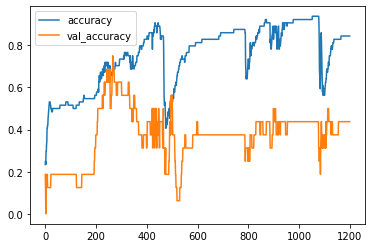

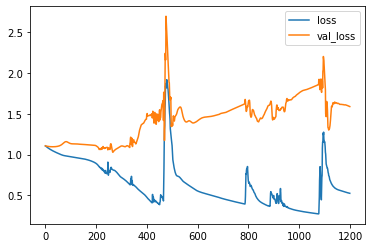

In [112]:
history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Max validation accuracy: {}".format(history_df['val_accuracy'].max()))

history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

# Transformer

Functions positional_encoding(positions, d), create_padding_mask(seq), create_look_ahead_mask(size), FullyConnected(embedding_dim, fully_connected_dim), Encoder(tf.keras.layers.Layer) are from the Deep Learning Specialization course on Coursera (Sequence Models). Also, there is a similar version in Artificial Neural Networks with TensorFlow 2 by Poornachandra Sarang.

In [ ]:
# This loads functions positional_encoding(positions, d), create_padding_mask(seq), 
# create_look_ahead_mask(size), FullyConnected(embedding_dim, fully_connected_dim), 
# Encoder(tf.keras.layers.Layer) 
from Transformer_subfunctions import *

In [ ]:
def reshapeY3D_a_Y1D(Y_bin):
    # Y_bin : (batch, timesteps, n_outputs) OU Y_bin : (batch, n_outputs)
    
    batch = Y_bin.shape[0]
    
    if len(Y_bin.shape) == 2:
        # Y_bin : (batch, n_outputs)
        temp = [np.argmax(Y_bin[i,:]) for i in range(batch)]   # (batch,)
    
    elif len(Y_bin.shape) == 3:
        # Y_bin : (batch, timesteps, n_outputs)
        temp = [np.argmax(Y_bin[i,0:1,:]) for i in range(batch)]   # (batch,)
    
    Y = np.array(temp)
    Y = np.reshape(Y, (batch,)) # Y : (batch, )
    
    return Y

In [ ]:
def run_Transformer(X_train, X_test, Y_train, Y_test, patience, batch_size, epochs):
    
    # X_train : (batch_train, timesteps_train, feature)
    # X_test : (batch_test, timesteps_test, feature)
    
    # Y_train : (batch_train, n_outputs)
    # Y_test : (batch_test, n_outputs)
    
    # -------------------------------
    
    batch_train = X_train.shape[0]
    timesteps_train = X_train.shape[1]
    feature = X_train.shape[2]
    
    batch_test = X_test.shape[0]
    timesteps_test = X_test.shape[1]
    
    n_outputs = Y_train.shape[1]
    
    # -------------------------------
    
    # Model architecture
    
    # Encoder (shuffling and transformation of the data)
    tf.random.set_seed(1)  #10
    
    # unique words, or unique data points to a certain precision
    precision = 0.1
    input_vocab_size=len(np.arange(0,1,precision))
    
    # the maximum number of words in each sentence, OR timesteps
    maximum_position_encoding = timesteps_train
    
    encoderq = Encoder(num_layers=6, embedding_dim=feature, num_heads=1, fully_connected_dim=2*feature, 
                       input_vocab_size=input_vocab_size,
                       maximum_position_encoding=maximum_position_encoding, dropout_rate=0.1, 
                       layernorm_eps=1e-6, textORnot='timeseries')
    
    training = True  # training for Dropout layers
    mask = None #create_padding_mask(X_train)  # create_look_ahead_mask(x.shape[1]) # None
    encoder_X_train = encoderq(X_train, training, mask)   # output is shape=(batch_train, timesteps_train, feature)
    
    mask = None #create_padding_mask(X_test)  # create_look_ahead_mask(x.shape[1]) # None
    encoder_X_test = encoderq(X_test, training, mask)   # output is shape=(batch_test, timesteps_test, feature)
    
    # -------------------------------
    
    # Final Fully Connected
    model = Sequential()
    initializer = tf.keras.initializers.HeUniform()
    if n_outputs > 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))

    # --------

    # Compile the model for training
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    if n_outputs > 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

    # -------------------------------
    
    X_train_1D = np.reshape(encoder_X_train, (batch_train, timesteps_train*feature))
    X_test_1D = np.reshape(encoder_X_test, (batch_test, timesteps_test*feature))
    
    verbose = 2
    #history = model.fit(X_train_1D, Y_train, epochs=epochs, 
    #                    validation_data=(X_test_1D, Y_test), 
    #                    batch_size=batch_size, callbacks=[early_stopping], verbose=verbose)
    history = model.fit(X_train_1D, Y_train, epochs=epochs, 
                        validation_data=(X_test_1D, Y_test), 
                        batch_size=batch_size, verbose=verbose)
    history_df = pd.DataFrame(history.history)
    
    # -------------------------------
    
    return model, history_df

In [ ]:
print('X_train2 : ', X_train2.shape)
print('y_train2 :', y_train2.shape)
print('X_test2 : ', X_test2.shape)
print('y_test2 :', y_test2.shape)

timesteps_train = X_train2.shape[1]
feature = X_train2.shape[2]

print('timesteps_train : ', timesteps_train)
print('feature : ', feature)

In [ ]:
patience = 5
batch_size = 64
epochs = 1200

# run_Transformer is located in subfunction_utility.py
model, history_df = run_Transformer(X_train2, X_test2, y_train2, y_test2, patience, batch_size, epochs)

In [ ]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Max validation accuracy: {}".format(history_df['val_accuracy'].max()))

# N-Layer NN

In [ ]:
def dcgan_arch(n_outputs, img0, den_activation):
    
    hidden_dim = 128
    
    model = Sequential()
    model.add(Dense(hidden_dim * 4, activation=den_activation, input_shape=(img0, )))
    model.add(Dense(hidden_dim * 2, activation=den_activation))
    model.add(Dense(hidden_dim, activation=den_activation))
    
    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.HeNormal()
    # initializer = tf.keras.initializers.GlorotUniform()
    if n_outputs > 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))

    # --------
    
    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if n_outputs > 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    
    # model.summary()
    
    return model

In [121]:
input_shape = X_train2.shape[1]*X_train2.shape[2]
print('input_shape: ', input_shape)

# output shape
n_outputs = y_train2.shape[1]
print('n_outputs: ', n_outputs)


X_train3 = np.reshape(X_train2, (X_train2.shape[0], X_train2.shape[1]*X_train2.shape[2]))
X_test3 = np.reshape(X_test2, (X_test2.shape[0], X_test2.shape[1]*X_test2.shape[2]))

input_shape:  2000
n_outputs:  3


In [122]:
den_activation = 'relu'

# dcgan_arch is located in subfunction_utility.py
model = dcgan_arch(n_outputs, input_shape, den_activation)
epochs = 200
patience = 20
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')

verbose = 2
history = model.fit(X_train3, y_train2, epochs=epochs, 
                validation_data=(X_test3, y_test2), 
                batch_size=batch_size, callbacks=[early_stopping], verbose=verbose)

history_df = pd.DataFrame(history.history)

Epoch 1/200
2/2 - 2s - loss: 1.2184 - accuracy: 0.4375 - precision_19: 0.4667 - recall_19: 0.3281 - auc_19: 0.5757 - val_loss: 1.1269 - val_accuracy: 0.3750 - val_precision_19: 0.5000 - val_recall_19: 0.3750 - val_auc_19: 0.6152 - 2s/epoch - 766ms/step
Epoch 2/200
2/2 - 0s - loss: 0.0953 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 1.1792 - val_accuracy: 0.5000 - val_precision_19: 0.5000 - val_recall_19: 0.3750 - val_auc_19: 0.6426 - 51ms/epoch - 26ms/step
Epoch 3/200
2/2 - 0s - loss: 0.0140 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 1.3126 - val_accuracy: 0.5625 - val_precision_19: 0.5333 - val_recall_19: 0.5000 - val_auc_19: 0.6299 - 49ms/epoch - 25ms/step
Epoch 4/200
2/2 - 0s - loss: 0.0045 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 1.4839 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5918 - 52ms/epo

Epoch 33/200
2/2 - 0s - loss: 1.6212e-05 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.8677 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.5000 - 47ms/epoch - 24ms/step
Epoch 34/200
2/2 - 0s - loss: 1.5618e-05 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.8589 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.4990 - 47ms/epoch - 23ms/step
Epoch 35/200
2/2 - 0s - loss: 1.5111e-05 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.8499 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.4971 - 42ms/epoch - 21ms/step
Epoch 36/200
2/2 - 0s - loss: 1.4618e-05 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.8412 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_

Epoch 65/200
2/2 - 0s - loss: 7.1208e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.6390 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.5234 - 40ms/epoch - 20ms/step
Epoch 66/200
2/2 - 0s - loss: 6.9830e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.6362 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.5234 - 43ms/epoch - 22ms/step
Epoch 67/200
2/2 - 0s - loss: 6.8545e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.6335 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.5244 - 44ms/epoch - 22ms/step
Epoch 68/200
2/2 - 0s - loss: 6.7204e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.6309 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_

Epoch 97/200
2/2 - 0s - loss: 3.6638e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5612 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.5312 - 47ms/epoch - 24ms/step
Epoch 98/200
2/2 - 0s - loss: 3.5986e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5609 - val_accuracy: 0.3750 - val_precision_19: 0.3750 - val_recall_19: 0.3750 - val_auc_19: 0.5312 - 50ms/epoch - 25ms/step
Epoch 99/200
2/2 - 0s - loss: 3.5167e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5612 - val_accuracy: 0.3750 - val_precision_19: 0.4000 - val_recall_19: 0.3750 - val_auc_19: 0.5312 - 46ms/epoch - 23ms/step
Epoch 100/200
2/2 - 0s - loss: 3.4384e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5628 - val_accuracy: 0.3750 - val_precision_19: 0.4000 - val_recall_19: 0.3750 - val_auc

Epoch 129/200
2/2 - 0s - loss: 1.9055e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5648 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5400 - 47ms/epoch - 24ms/step
Epoch 130/200
2/2 - 0s - loss: 1.8664e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5648 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5400 - 49ms/epoch - 24ms/step
Epoch 131/200
2/2 - 0s - loss: 1.8328e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5649 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5400 - 39ms/epoch - 20ms/step
Epoch 132/200
2/2 - 0s - loss: 1.7956e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5653 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_

Epoch 161/200
2/2 - 0s - loss: 1.0803e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5752 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5430 - 52ms/epoch - 26ms/step
Epoch 162/200
2/2 - 0s - loss: 1.0617e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5751 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5439 - 62ms/epoch - 31ms/step
Epoch 163/200
2/2 - 0s - loss: 1.0449e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5758 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5439 - 53ms/epoch - 26ms/step
Epoch 164/200
2/2 - 0s - loss: 1.0245e-06 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5766 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_

Epoch 193/200
2/2 - 0s - loss: 6.8918e-07 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5945 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5479 - 55ms/epoch - 27ms/step
Epoch 194/200
2/2 - 0s - loss: 6.7800e-07 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5954 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5479 - 57ms/epoch - 28ms/step
Epoch 195/200
2/2 - 0s - loss: 6.6683e-07 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5958 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_auc_19: 0.5479 - 50ms/epoch - 25ms/step
Epoch 196/200
2/2 - 0s - loss: 6.6124e-07 - accuracy: 1.0000 - precision_19: 1.0000 - recall_19: 1.0000 - auc_19: 1.0000 - val_loss: 2.5974 - val_accuracy: 0.4375 - val_precision_19: 0.4375 - val_recall_19: 0.4375 - val_

Minimum validation loss: 1.1268706321716309
Max validation accuracy: 0.5625


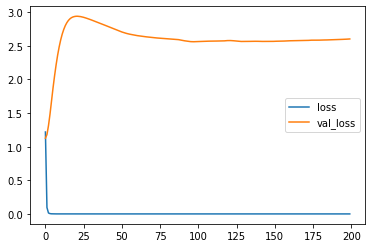

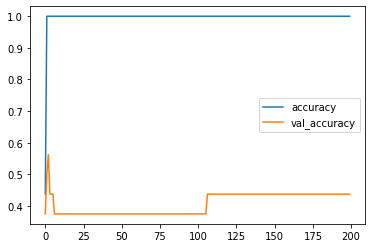

In [123]:
history_df.loc[:, ['loss', 'val_loss']].plot();
print("Minimum validation loss: {}".format(history_df['val_loss'].min()))

history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
print("Max validation accuracy: {}".format(history_df['val_accuracy'].max()))

# CNN

In [ ]:
# MaxPooling Convolutional 2D repeating layers

def MPCNN_arch(n_outputs, img_dim, rgb_layers, mod):
    
    # Typical architecture MPCNN architecture using alternating convolutional and max-pooling layers. 
    
    model = Sequential()  # initialize Sequential model
    
    if mod == 0:
        model.add(Conv2D(32, (5,5), strides=(1,1), padding='same', input_shape=(img_dim, img_dim, rgb_layers)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Conv2D(32 * 2, (5,5), strides=(1,1), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))
        model.add(Flatten())
    elif mod == 1:
        model.add(Conv2D(8,(4,4), strides=(1,1), padding='same', input_shape=(img_dim, img_dim, rgb_layers)))
        model.add(Activation('relu'))
        model.add(MaxPooling2D((8,8), strides=(8,8), padding='same'))
        model.add(Conv2D(16,(2,2), strides=(1,1), padding='same'))
        model.add(Activation('relu'))
        model.add(MaxPooling2D((4,4), strides=(4,4), padding='same'))
        model.add(Flatten())
        model.add(Dense(100, activation='relu'))
    elif mod == 2:
        # 2D Convolutional model using MFCC
        model.add(Conv2D(32, (4,10), padding="same", input_shape=(img_dim, img_dim, rgb_layers)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='same'))
        
        model.add(Conv2D(32, (4,10), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='same'))

        model.add(Conv2D(32, (4,10), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='same'))

        model.add(Conv2D(32, (4,10), padding="same"))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1), padding='same'))

        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
    elif mod == 3:
        # 1D Convolutional model using MFCC
        inp = Input(shape=(input_length,1))
        x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
        x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
        x = MaxPool1D(16)(x)
        x = Dropout(rate=0.1)(x)

        x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
        x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
        x = MaxPool1D(4)(x)
        x = Dropout(rate=0.1)(x)

        x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
        x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
        x = MaxPool1D(4)(x)
        x = Dropout(rate=0.1)(x)

        x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
        x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
        x = GlobalMaxPool1D()(x)
        x = Dropout(rate=0.2)(x)

        x = Dense(64, activation=relu)(x)
        x = Dense(1028, activation=relu)(x)
        out = Dense(nclass, activation=softmax)(x)

    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.HeNormal()
    # initializer = tf.keras.initializers.GlorotUniform()
    if n_outputs > 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))
    
    print('model.output_shape :', model.output_shape)
    # model.output_shape : (None, 1)
    # --------
    
    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if n_outputs > 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    
    # model.summary()
    
    return model

In [ ]:
def encoderdecoder_arch(n_outputs, img_dim, rgb_layers):
    
    base_dimension = 64          
    
    model = Sequential()
    # 1ère valeur (filters) : le nombre de tranches "(kernel_val,kernel_val)" qui composent l'image de sortie
    # 2eme valeur (kernel_size) : la taille de la carre/filtre que on glisse au dessous l'image 
    # 3eme valeur (stride): Le plus grande le stride valeur le plus petite l'image sortie : on prends z_dim/stride_num
    
    # --------
    # Entrée = (img_dim, img_dim, 1)
    model.add(Conv2D(base_dimension, (5,5), strides=(2,2), padding='same', input_shape=(img_dim, img_dim, rgb_layers)))
    print('model.output_shape :', model.output_shape)
    # Sortie = 
    # taille_sortie = (28 + 2*p - 5)/2 + 1

    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    # --------

    # --------
    # Entrée = 
    model.add(Conv2D(base_dimension * 2, (5,5), strides=(2,2), padding='same'))
    print('model.output_shape :', model.output_shape)
    # Sortie = 

    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    # --------

    # --------
    model.add(Flatten())

    print('model.output_shape :', model.output_shape)
    # model.output_shape : (None, 4096)
    # --------
    
    initializer = tf.keras.initializers.HeUniform()
    # initializer = tf.keras.initializers.HeNormal()
    # initializer = tf.keras.initializers.GlorotUniform()
    if n_outputs > 2:
        model.add(Dense(n_outputs, activation='softmax', kernel_initializer=initializer))
    else:
        model.add(Dense(n_outputs, activation='sigmoid', kernel_initializer=initializer))
    
    print('model.output_shape :', model.output_shape)
    # model.output_shape : (None, 1)
    # --------
    
    # Compile the model for training
    opt = keras.optimizers.Adam()
    # opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
    if n_outputs > 2:
        model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    else:
        model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()])  # optimizer='adam'
    
    # model.summary()
    
    return model

In [ ]:
def initialize_CNN(X_train, X_test, Y_train, Y_test, img_dim): 
    
    # X_train: (batch_train, timesteps_train, feature_train)
    # Y_train: (batch_train, timesteps_train, n_outputs)
    # X_test: (batch_test, timesteps_test, feature_train)
    # Y_test: (batch_test, timesteps_test, n_outputs)
    
    batch_train = X_train.shape[0]
    batch_test = X_test.shape[0]
    
    # ----------------
    
    # Tranformez X(batch, timestamps, feature) into X(batch, img_dim, img_dim, 3)
    X_train_img = Xbtf_2_Xbii3(X_train, img_dim, batch_train)
    X_test_img = Xbtf_2_Xbii3(X_test, img_dim, batch_test)
    
    # ----------------
    
    # Enlevez timesteps
    if len(Y_train.shape) == 3:
        Y_train =  [Y_train[i,0:1,:] for i in range(batch_train)]
        Y_test =  [Y_test[i,0:1,:] for i in range(batch_test)]

    Y_train = np.array(Y_train)
    Y_test = np.array(Y_test)
    
    # ----------------
    
    # shape of X_train_img :  (batch_train, img_dim, img_dim, 3)
    # shape of Y_train :  (batch_train, n_outputs)
    # shape of X_test_img :  (batch_test, img_dim, img_dim, 3)
    # shape of Y_test :  (batch_test, n_outputs)
    
    X_train_img = np.asarray(X_train_img, dtype = np.float16, order ='C')  # np.float16, np.float32, np.float64
    Y_train = np.asarray(Y_train, dtype = np.float16, order ='C')
    X_test_img = np.asarray(X_test_img, dtype = np.float16, order ='C')
    Y_test = np.asarray(Y_test, dtype = np.float16, order ='C')
    
    print('X_train_img:' , X_train_img.shape)
    print('Y_train:' , Y_train.shape)
    print('X_test_img:' , X_test_img.shape)
    print('Y_test:' , Y_test.shape)
    
    return X_train_img, X_test_img, Y_train, Y_test
    
    
# Tranformez X(batch, timestamps, feature) into X(batch, img_dim, img_dim, 3)
def Xbtf_2_Xbii3(X, img_dim, batch):
    X_img = []
    for i in range(batch):
        X_1D = X[i,:,:].flatten()
        
        if i == 0:
            n = int(np.floor(np.sqrt(len(X_1D))))
    
        # fold into a square
        mat = np.reshape(X_1D[0:n*n], (n, n))
    
        image = imgORmat_resize_imgORmat_CNN(img_dim, mat, inpt='mat2D', outpt='img3D', norm='non', thresh='non')
        
        X_img.append(image)
    
    X_img = np.array(X_img)
    
    return X_img

In [ ]:
def run_CNN(X_train, X_test, Y_train, Y_test, patience, batch_size, epochs):
    
    # X_train: (batch_train, timesteps_train, feature_train)
    # Y_train: (batch_train, timesteps_train, n_outputs)
    # X_test: (batch_test, timesteps_test, feature_train)
    # Y_test: (batch_test, timesteps_test, n_outputs)
    
    # ----------------
    img_dim = 64
    
    # Folding data into CNN image format:
    X_train_img, X_test_img, Y_train, Y_test  = initialize_CNN(X_train, X_test, Y_train, Y_test, img_dim)
    
    # shape of X_train_img :  (batch_train, img_dim, img_dim, 3)
    # shape of Y_train :  (batch_train, n_outputs)
    # shape of X_test_img :  (batch_test, img_dim, img_dim, 3)
    # shape of Y_test :  (batch_test, n_outputs)
    
    n_outputs = Y_test.shape[1]
    
    # ----------------
    
    # Model architecture
    epochs = 100
    batch_size = 32
    patience = 5
    
    tot = []
    tot_mod = []
    mod_type = ['mpcnn', 'encdec'] # CNN model architecture type
    rgb_layers = X_train_img.shape[3]
    
    for i in range(2):
        if i == 0:
            mod = 2 # 0, 1, 2, 3=1D
            model = MPCNN_arch(n_outputs, img_dim, rgb_layers, mod)
        elif i == 1:
            model = encoderdecoder_arch(n_outputs, img_dim, rgb_layers)
            
    
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience, mode='min')
        
        # -------------------------------
        
        history = model.fit(X_train_img, Y_train, epochs=epochs, validation_data=(X_test_img, Y_test), batch_size=batch_size, callbacks=[early_stopping], verbose=2)
        
        history_df = pd.DataFrame(history.history)
        
        history_df.loc[:, ['loss', 'val_loss']].plot();
        print("Max validation loss: {}".format(history_df['val_loss'].max()))
        
        history_df.loc[:, ['accuracy', 'val_accuracy']].plot();
        print("Max validation accuracy: {}".format(history_df['val_accuracy'].max()))
        
        out = [history_df.iloc[:,i].mean() for i in range(len(history_df.columns))]
    
        tot.append(out)
        tot_mod.append(model)
    
    tot = np.array(tot)
    
    # -------------------------------
    
    a = np.argmax(tot[:,1])  # train
    b = np.argmax(tot[:,6])  # test
    suf = ['train', 'test']
    tr_noms = ['loss_', 'acc_', 'prec_', 'recall_', 'roc_auc_']

    list2 = [j+i for i in suf for j in tr_noms]
    list2

    dict_out = {}
    for i in range(len(list2)):
        if i < len(list2)/2:
            r = tot[a,i]
        else:
            r = tot[b,i]
        dict_out[list2[i]] = r


    # ajoutez au dictionaire
    dict_out['mod_train'] = mod_type[a]
    dict_out['mod_test'] = mod_type[b]

    # -------------------------------

    cnn2D_model_best = tot_mod[b]
    
    # -------------------------------
    
    return cnn2D_model_best, dict_out

In [119]:
print('X_train2.shape : ', X_train2.shape)
print('X_test2.shape : ', X_test2.shape)
print('y_train2.shape : ', y_train2.shape)
print('y_test2.shape : ', y_test2.shape)

X_train2.shape :  (64, 500, 4)
X_test2.shape :  (16, 500, 4)
y_train2.shape :  (64, 3)
y_test2.shape :  (16, 3)


/tmp/ipykernel_3704/4201317593.py:14: DeprecationWarning:

ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.



X_train_img: (64, 64, 64, 3)
Y_train: (64, 3)
X_test_img: (16, 64, 64, 3)
Y_test: (16, 3)
model.output_shape : (None, 3)
Epoch 1/100
2/2 - 7s - loss: 1.6120 - accuracy: 0.4062 - precision_17: 0.3519 - recall_17: 0.2969 - auc_17: 0.5687 - val_loss: 111.3716 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 7s/epoch - 4s/step
Epoch 2/100
2/2 - 5s - loss: 0.2140 - accuracy: 0.9844 - precision_17: 1.0000 - recall_17: 0.9844 - auc_17: 0.9999 - val_loss: 105.8604 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 5s/epoch - 2s/step
Epoch 3/100
2/2 - 5s - loss: 0.1503 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 0.9844 - auc_17: 1.0000 - val_loss: 94.5431 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 5s/epoch - 2s/step
Epoch 4/100
2/2 - 5s - loss: 0.1264 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_los

Epoch 34/100
2/2 - 5s - loss: 0.0146 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 10.6850 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 5s/epoch - 2s/step
Epoch 35/100
2/2 - 5s - loss: 0.0131 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 10.2426 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 5s/epoch - 2s/step
Epoch 36/100
2/2 - 5s - loss: 0.0146 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 9.7965 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 5s/epoch - 2s/step
Epoch 37/100
2/2 - 5s - loss: 0.0141 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 9.3799 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.3906 - 5s/epoch - 3s

Epoch 67/100
2/2 - 5s - loss: 0.0056 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 2.9891 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.4922 - 5s/epoch - 2s/step
Epoch 68/100
2/2 - 5s - loss: 0.0074 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 2.8545 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.4854 - 5s/epoch - 2s/step
Epoch 69/100
2/2 - 5s - loss: 0.0055 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 2.7280 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.4922 - 5s/epoch - 2s/step
Epoch 70/100
2/2 - 5s - loss: 0.0063 - accuracy: 1.0000 - precision_17: 1.0000 - recall_17: 1.0000 - auc_17: 1.0000 - val_loss: 2.6098 - val_accuracy: 0.1875 - val_precision_17: 0.1875 - val_recall_17: 0.1875 - val_auc_17: 0.4893 - 5s/epoch - 3s/s

Epoch 28/100
2/2 - 0s - loss: 1.8626e-09 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000 - auc_18: 1.0000 - val_loss: 15.1839 - val_accuracy: 0.5000 - val_precision_18: 0.5000 - val_recall_18: 0.5000 - val_auc_18: 0.6426 - 366ms/epoch - 183ms/step
Epoch 29/100
2/2 - 0s - loss: 1.3235e-04 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000 - auc_18: 1.0000 - val_loss: 15.7884 - val_accuracy: 0.5000 - val_precision_18: 0.5000 - val_recall_18: 0.5000 - val_auc_18: 0.6426 - 327ms/epoch - 164ms/step
Epoch 30/100
2/2 - 0s - loss: 7.5605e-06 - accuracy: 1.0000 - precision_18: 1.0000 - recall_18: 1.0000 - auc_18: 1.0000 - val_loss: 16.3164 - val_accuracy: 0.5000 - val_precision_18: 0.5000 - val_recall_18: 0.5000 - val_auc_18: 0.6426 - 362ms/epoch - 181ms/step
Max validation loss: 239.25209045410156
Max validation accuracy: 0.6875


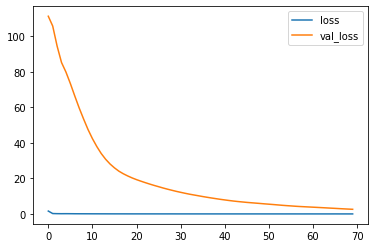

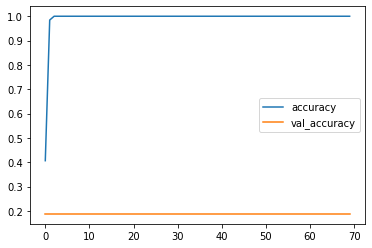

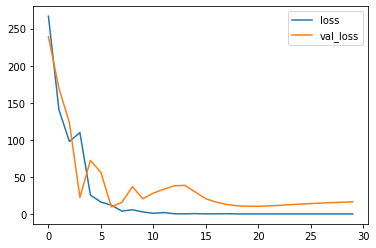

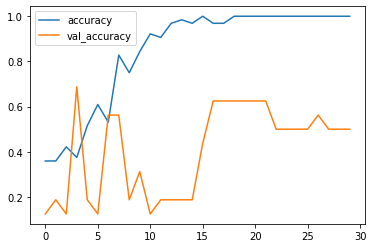

In [120]:
epochs = 200
batch_size = 32
patience = 20

# run_CNN is located in subfunction_utility.py
cnn2D_model_best, dict_out = run_CNN(X_train2, X_test2, y_train2, y_test2, patience, batch_size, epochs)

In [97]:
dict_out

{'loss_train': 2.094554203326552,
 'acc_train': 0.94450000166893,
 'prec_train': 0.9424422553181648,
 'recall_train': 0.9392500013113022,
 'roc_auc_train': 0.9513843742012977,
 'loss_test': 13.67975360696966,
 'acc_test': 0.5909091125835072,
 'prec_test': 0.548178774840904,
 'recall_test': 0.5757575929164886,
 'roc_auc_test': 0.5809091194109484,
 'mod_train': 'mpcnn',
 'mod_test': 'encdec'}